<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preprocess" data-toc-modified-id="Data-Preprocess-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preprocess</a></span></li><li><span><a href="#Data-Visualizaion" data-toc-modified-id="Data-Visualizaion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Visualizaion</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-Inventory-Data" data-toc-modified-id="Analysis-of-Inventory-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analysis of Inventory Data</a></span></li><li><span><a href="#Analysis-of-Sale-Data" data-toc-modified-id="Analysis-of-Sale-Data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analysis of Sale Data</a></span></li></ul></li></ul></div>

## Data Preprocess

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
df_inventory= pd.read_csv('Data/df_inventory_modified.csv')
df_products= pd.read_csv('Data/df_products_modified.csv')
df_transactions= pd.read_csv('Data/df_transactions_modified.csv')

In [4]:
df_a = pd.merge(df_products, df_inventory, on=['product_id',
                                               'color']).drop_duplicates()
df_a = df_a.groupby(
    ['week', 'season', 'group1', 'group2', 'group3', 'color',
     'supplier']).agg({
         'price': 'mean',
         'end_stock': 'median'
     }).reset_index().drop_duplicates()

#rounding the price for better readability in the plots
df_a['price'] = df_a['price'].apply(lambda x: round(x / 10) * 10)

In [5]:
# Functionm to map factor and categorical variables to integers


def integer_encoder(data, name_columns, verbose=0):
    encoder = LabelEncoder()
    for i in name_columns:
        encoder.fit(data[i])

        if verbose:
            print(encoder.classes_, 'map to: ',
                  encoder.transform(encoder.classes_), "\n")

        data[i] = encoder.transform(data[i])
    return data

In [6]:
# Defining categorical variables
name_columns = [
    'color', 'season', 'group1', 'group2', 'group3', 'color', 'supplier'
]

df_a = integer_encoder(df_a, name_columns)

week            AxesSubplot(0.125,0.749828;0.352273x0.130172)
season       AxesSubplot(0.547727,0.749828;0.352273x0.130172)
group1          AxesSubplot(0.125,0.593621;0.352273x0.130172)
group2       AxesSubplot(0.547727,0.593621;0.352273x0.130172)
group3          AxesSubplot(0.125,0.437414;0.352273x0.130172)
color        AxesSubplot(0.547727,0.437414;0.352273x0.130172)
supplier        AxesSubplot(0.125,0.281207;0.352273x0.130172)
price        AxesSubplot(0.547727,0.281207;0.352273x0.130172)
end_stock          AxesSubplot(0.125,0.125;0.352273x0.130172)
dtype: object

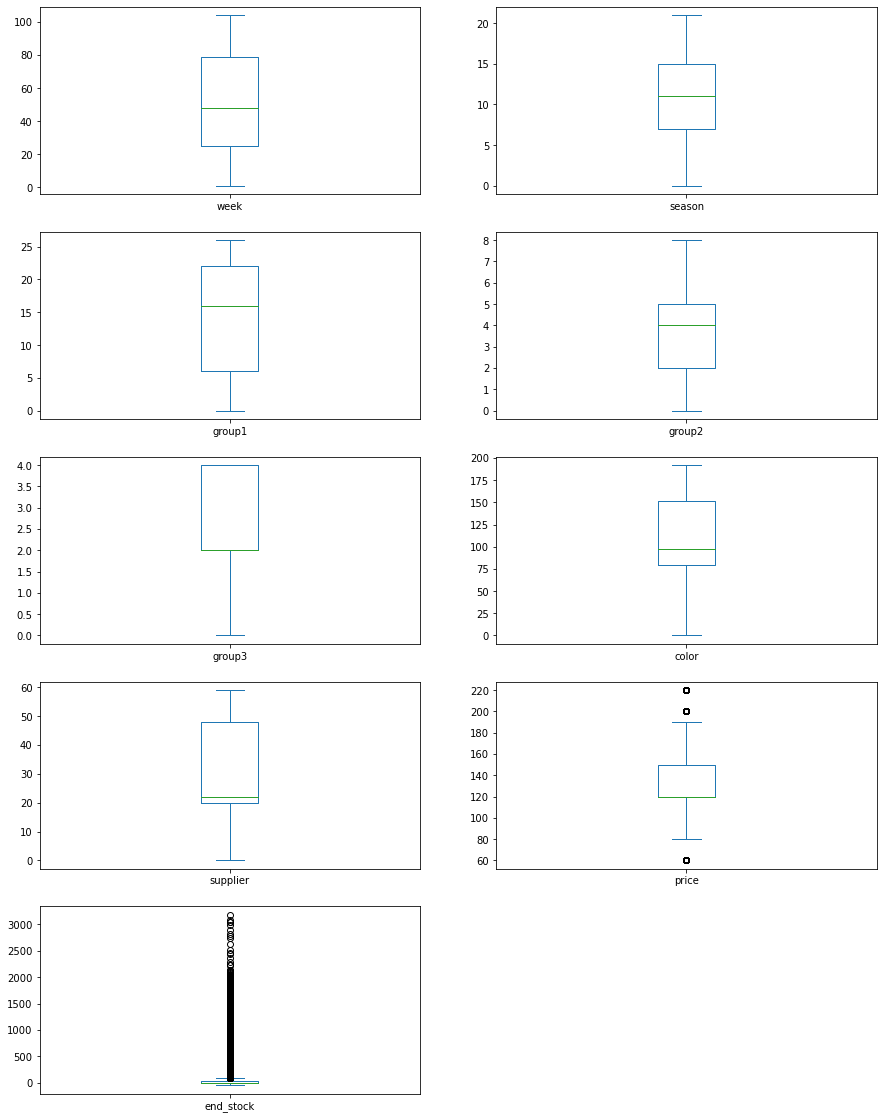

In [7]:
# Plor bosplot of all columns in the dataset
df_a.plot(kind="box",subplots=True,layout=(5,2),figsize=(15,20))

End_stock feature does not necessarily show outliers but for the readability of some visualizations, I replaced very small/big values with the upper band or the lower band based on its quartiles.

In [8]:
def cap_outliers(df, cols, upper_pct, lower_pct):
    """
    This function takes a dataframe, a list of columns, upper percentile and lower percentile as inputs. 
    for each column in the list, it replaces all the values above upper percentile with upper percentile value, and all the values below lower percentile with lower percentile value.
    It returns the modified dataframe with capped values in the specified columns.
    """
    for col in cols:
        # calculate the upper and lower limits
        upper_limit = df[col].quantile(upper_pct)
        lower_limit = df[col].quantile(lower_pct)
        # replace values above upper limit with upper limit
        df[col] = df[col].apply(lambda x: upper_limit if x > upper_limit else x)
        # replace values below lower limit with lower limit
        df[col] = df[col].apply(lambda x: lower_limit if x < lower_limit else x)

    return df

end_stock       AxesSubplot(0.125,0.125;0.352273x0.755)
price        AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

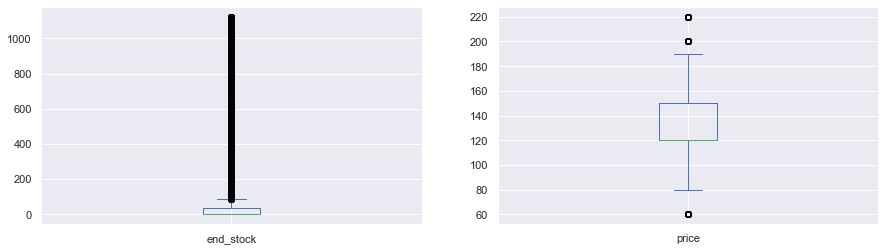

In [9]:
df_a_capped = cap_outliers(df_a,['end_stock'],0.98,0.02)
sns.set(font_scale = 1)
df_a[['end_stock','price']].plot(kind="box",subplots=True,layout=(1,2),figsize=(15,4))

end_stock    AxesSubplot(0.125,0.125;0.352273x0.755)
dtype: object

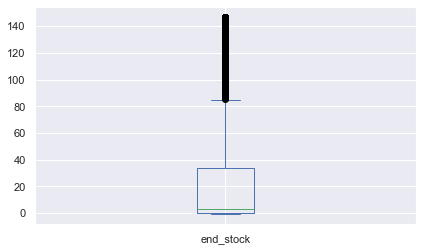

In [10]:
# Trying that one more time for only 'end_stock' to try to fix the outlier above the higher percentile
df_a_capped = cap_outliers(df_a_capped,['end_stock'],0.85,0)
sns.set(font_scale = 1)
df_a_capped['end_stock'].plot(kind="box",subplots=True,layout=(1,2),figsize=(15,4))

In [11]:
#merging the previous dataframes with information in transaction table 
df = pd.merge(df_inventory,df_products,on=['product_id','color']).drop_duplicates()
df_b = pd.merge(df,df_transactions,on=['product_id','week']).drop_duplicates()

promo_column = abs (df_b["purchase_price"] / df_b["price_x"]).map('{:,.1f}'.format)
df_b["promo"] = promo_column

#df_b = df_b.drop(['price_y','transaction_id', 'price_paid', 'purchase_price', 'Unnamed: 0_x', 'Unnamed: 0_y','Unnamed: 0'], axis=1)
df_b = df_b.groupby(['color','week','price_x','season','group1', 'group2','group3','supplier','shop','promo' ]).agg({ 'quantity' : 'sum', 'end_stock' : 'median' }).reset_index()
df_b.rename(columns = {'price_x':'price', 'quantity' : 'sold'}, inplace = True)

In [12]:
#rounding the price for better readability in the plots
df_b['price'] = df_b['price'].apply(lambda x: round(x / 10) * 10)

# Defining categorical variables
name_columns =['color', 'season', 'group1', 'group2', 'group3',
       'supplier', 'shop']

df_b = integer_encoder(df_b, name_columns)

price           AxesSubplot(0.125,0.787927;0.352273x0.0920732)
end_stock    AxesSubplot(0.547727,0.787927;0.352273x0.0920732)
sold            AxesSubplot(0.125,0.677439;0.352273x0.0920732)
dtype: object

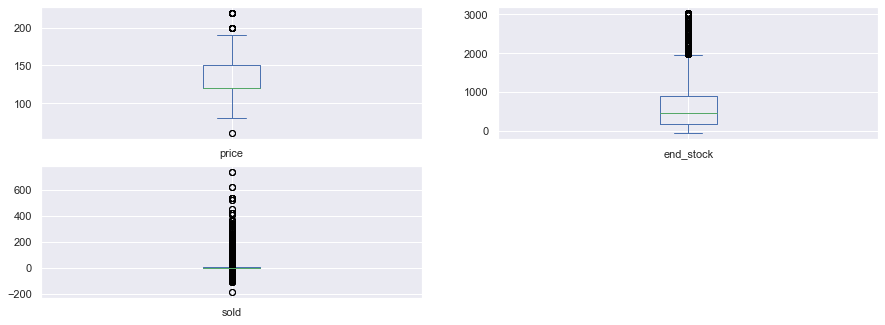

In [13]:
# Plor bosplot of all columns in the dataset
df_b[['price', 'end_stock', 'sold']].plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20))

end_stock       AxesSubplot(0.125,0.125;0.227941x0.755)
sold         AxesSubplot(0.398529,0.125;0.227941x0.755)
price        AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

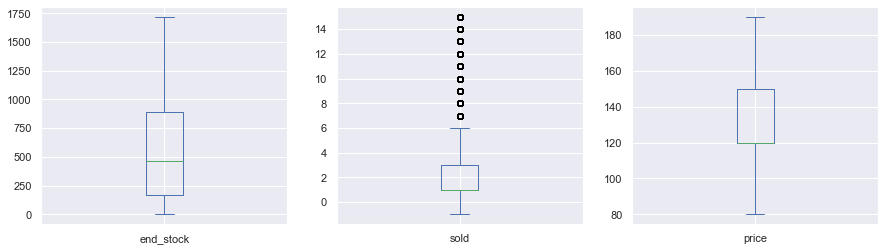

In [14]:
#replacing ouliers
df_b_capped = cap_outliers(df_b,['end_stock', 'sold', 'price'],0.98,0.02)
sns.set(font_scale = 1)
df_b[['end_stock','sold', 'price']].plot(kind="box",subplots=True,layout=(1,3),figsize=(15,4))

## Data Visualizaion

In [15]:
def freq_df(dataframe, feature):
    
    df = dataframe.copy()
    
    #create a new column that calculates the frequency of each price as a percentage
    df['freq'] = df.groupby(feature)[feature].transform('count')/df.shape[0]*100

    #select only rows from the dataframe where the frequency of the feature is greater than 1% of the total dataset.
    df = df[df['freq'] >= 5]
    
    return df

def plot_distribution_ratio(dataframe, feature, target, show_df = False):    
    df = freq_df(dataframe, feature)
    
    if target == "end_stock":    
        df = df.groupby([feature, 'freq']).agg({target : 'median'}).reset_index().drop_duplicates()
    else:
        df = df.groupby([feature, 'freq']).agg({target : 'sum'}).reset_index().drop_duplicates()
     #create a new column that calculates the ratio of the target to the feature
    df['ratio'] = df[target] / df['freq']
    
    if show_df: 
        #sort the dataframe by 'stock_price_ratio' column in descending order
        display(df.sort_values(by='ratio', ascending=False))
          
    sns.set(font_scale = 1)
    ax = df.groupby([feature]).sum().plot(figsize = (8,8),
    kind='pie', y='ratio', autopct='%1.0f%%', legend=None)
    ax.set_title("Distribution of " + target + " items based on their " + feature,  fontsize=16, fontweight='bold')
    plt.show()

    


    

### Analysis of Inventory Data

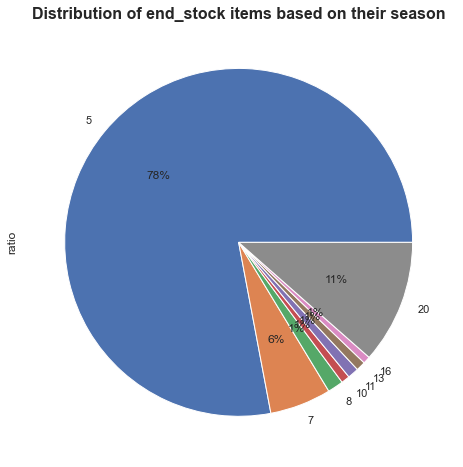

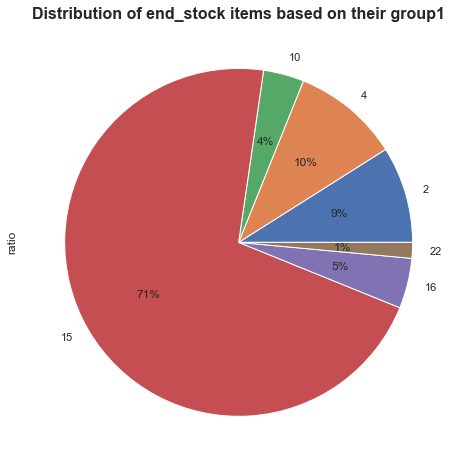

C:\Users\V\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1841: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


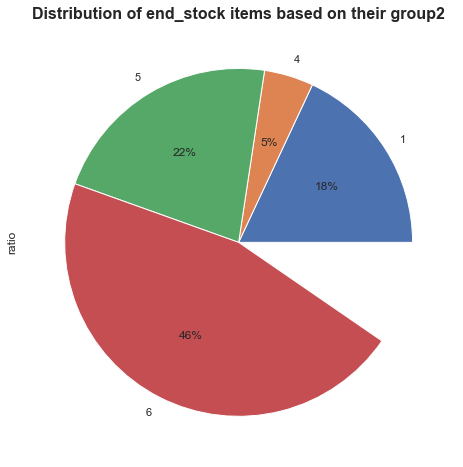

C:\Users\V\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1841: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


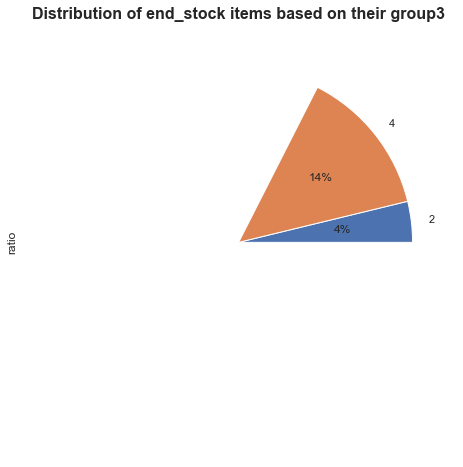

C:\Users\V\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1841: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


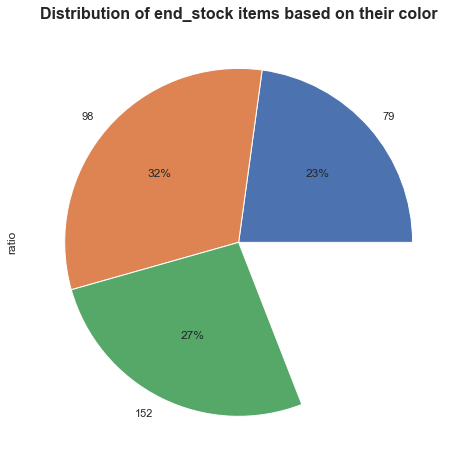

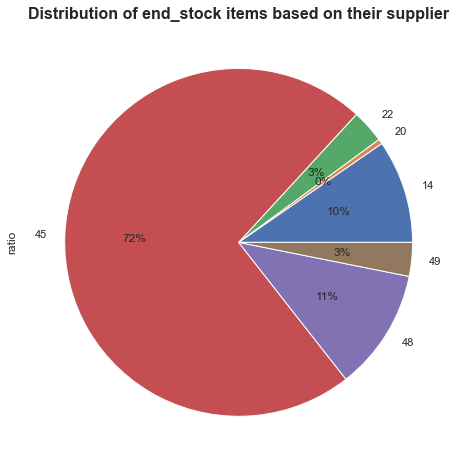

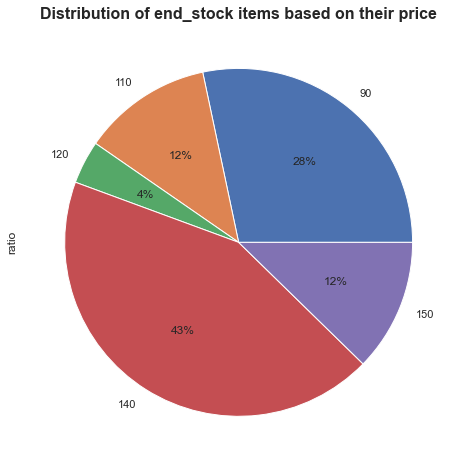

In [16]:
#find the features we want to plot
features = list(df_a.columns.values)

features = list(filter(lambda i: i not in ('week','end_stock'), features))

#plot the ratio of the stocked items per feature based on the frequency of that feature in the dataframe        
for f in features: 
    plot_distribution_ratio(df_a, f, 'end_stock')    

The figures above depict the relationship between the quantity of items in stock and the characteristics of said items. By taking into account the prevalence of each feature within the dataset, we are able to gain a more nuanced understanding of the distribution of our inventory. Specifically, a high ratio for a particular feature suggests that there is less demand for items with that characteristic and a higher likelihood that they will end up being stocked. Overall, these findings highlight the importance of considering both price and category when making inventory management decisions.

The above analysis demonstrates that some features play a much more significant role in determining the likelihood of an item ending up in inventory. In order to better understand and manage our inventory, I have made the decision to eliminate any products with specific features that contribute to less than 5% of our inventory, allowing us to focus on the more important and impactful factors at play.

C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Number of stocked items of each season per week')

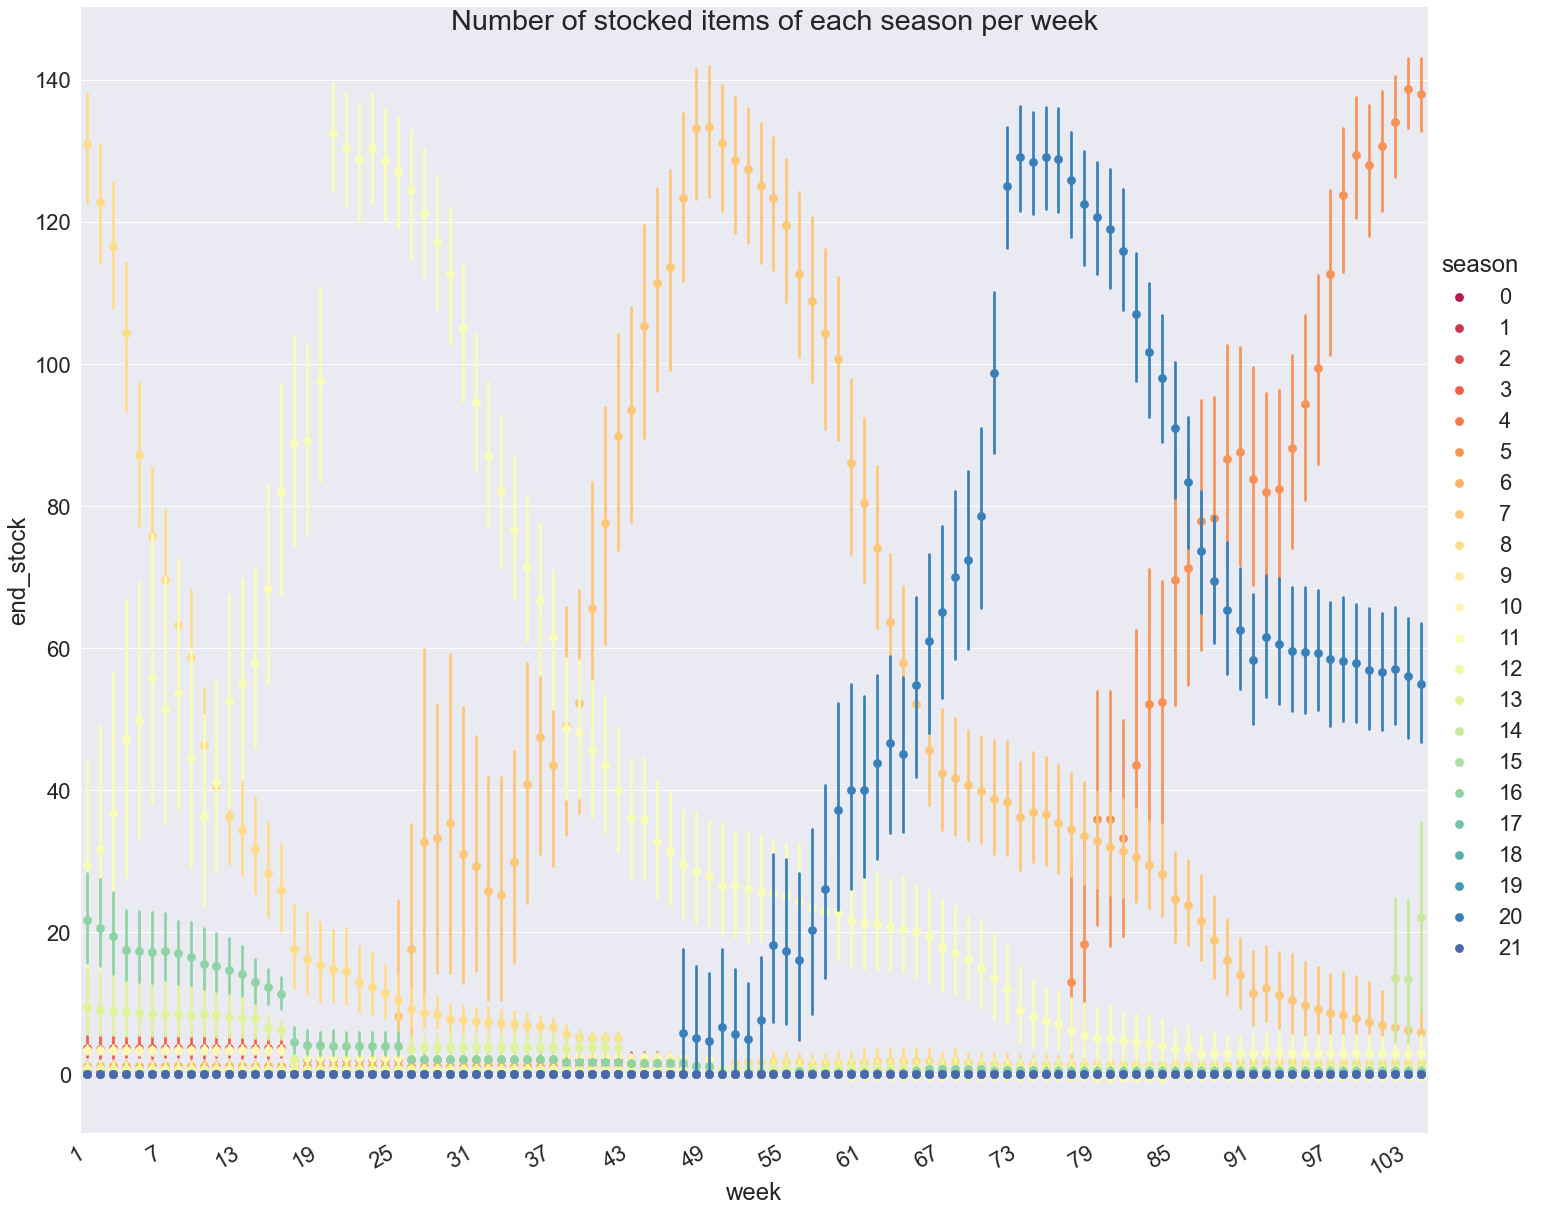

In [17]:
#plot weekly pattern of inventory items for each season
sns.set(font_scale = 2)
g = sns.factorplot(data=df_a, x="week", y="end_stock", hue='season',size=20,palette='Spectral',join=False,)
g.ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))
g.fig.autofmt_xdate()
g.fig.suptitle('Number of stocked items of each season per week')

In [18]:
def timeseries_distribution_ratio(dataframe, feature, target, time,  show_df = False):
    df = freq_df(dataframe, feature)
    
    sns.set(font_scale = 2)
    g = sns.factorplot(x=time, y=target, data=df, hue=feature,size=20,palette='Spectral',join=False,)
    g.ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))
    g.fig.autofmt_xdate()
    
    g.fig.suptitle('Number of stocked items per ' + time + ' and distribution of ' + feature + ' category among them')

C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update

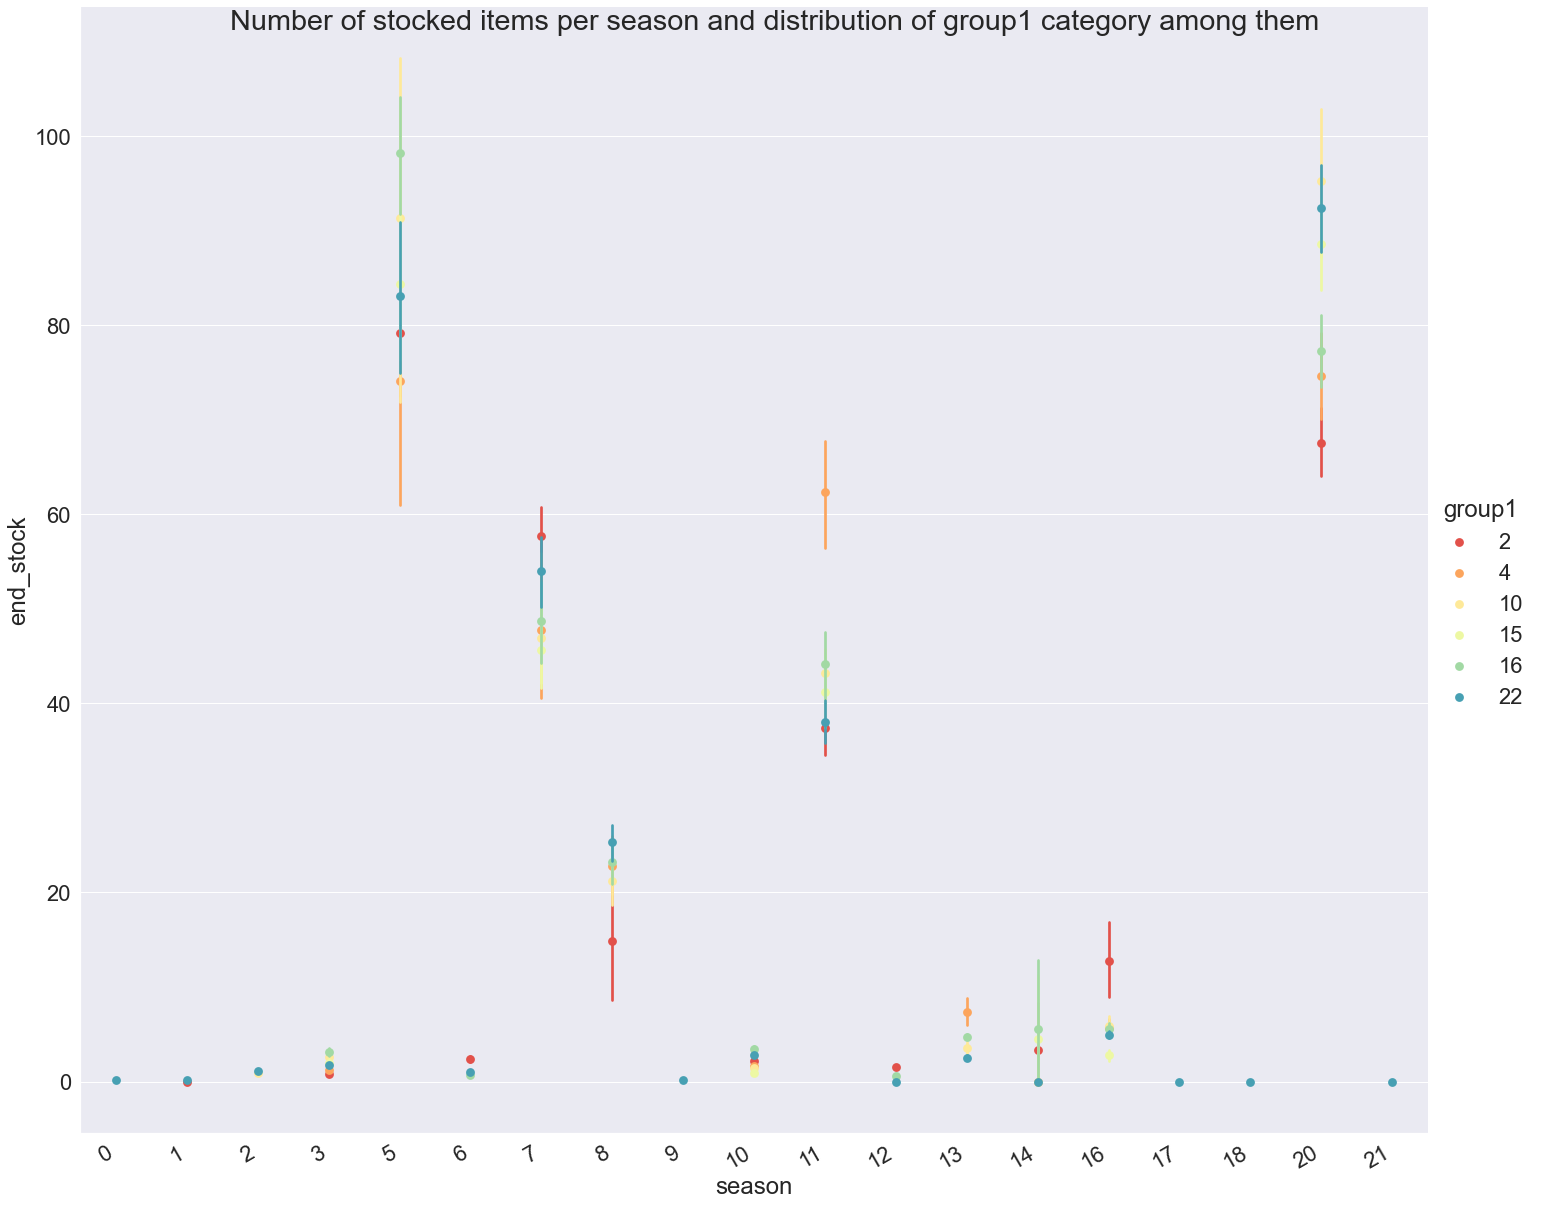

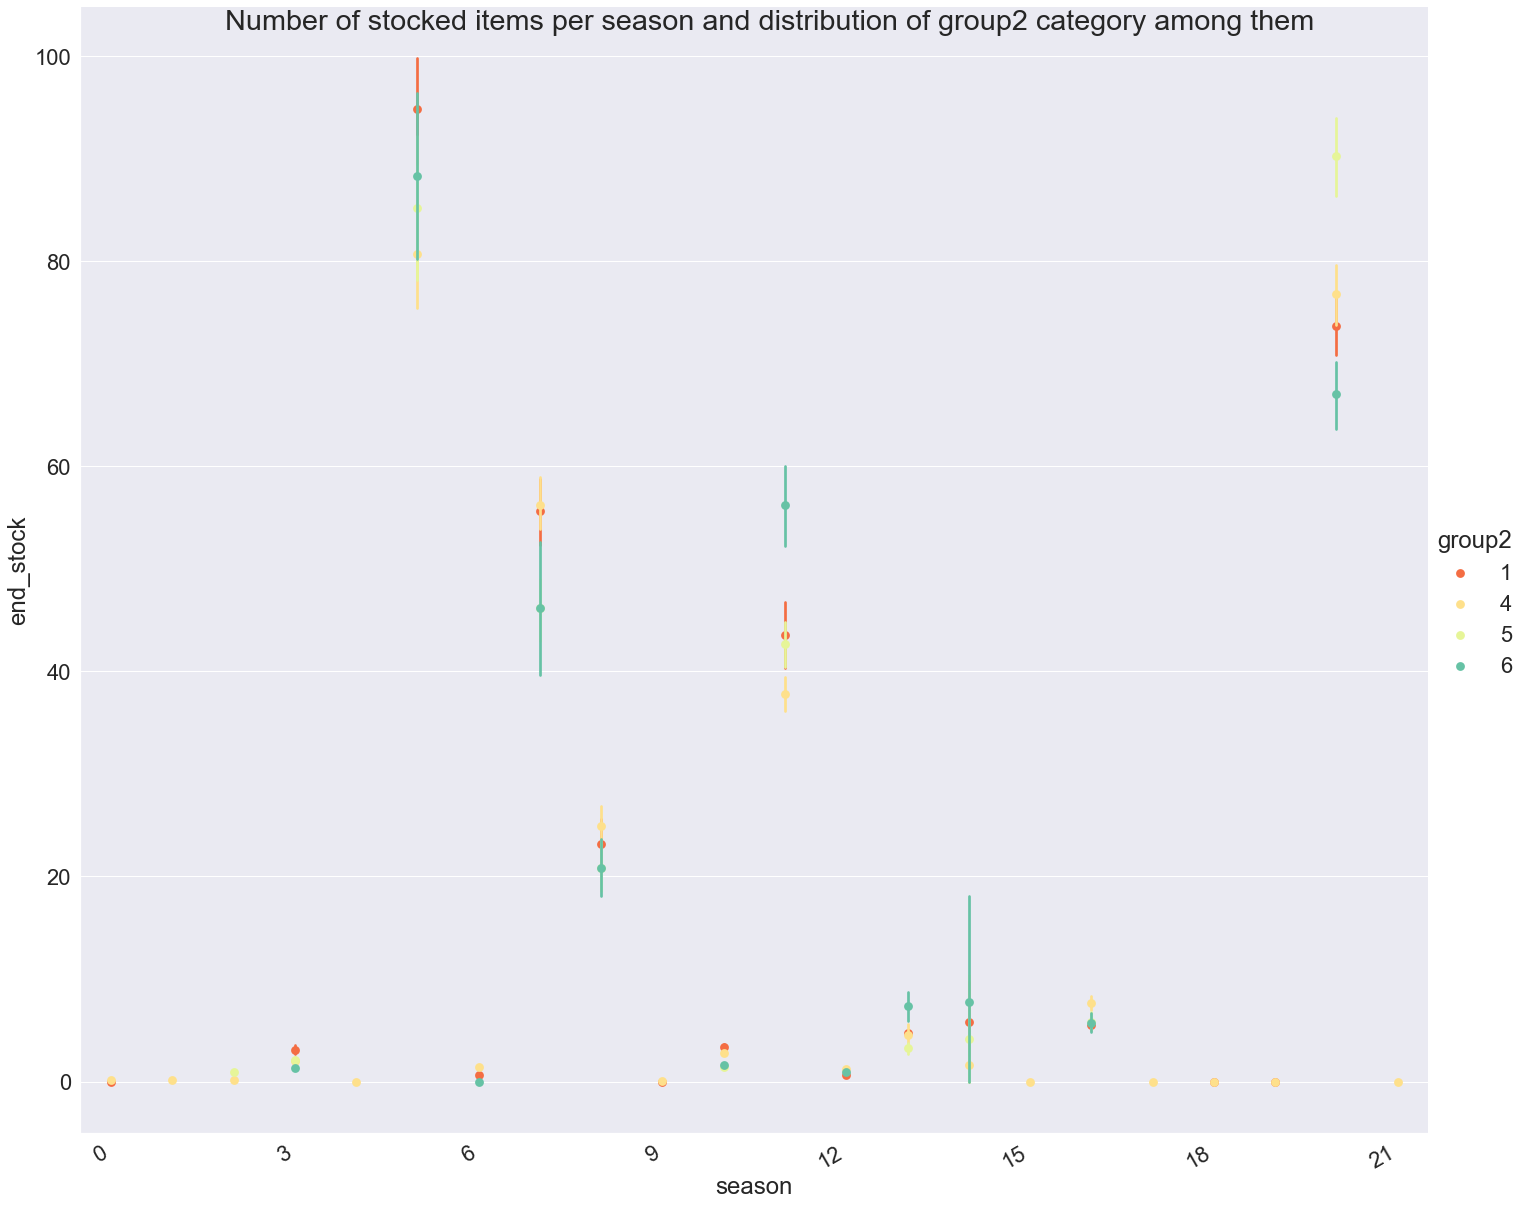

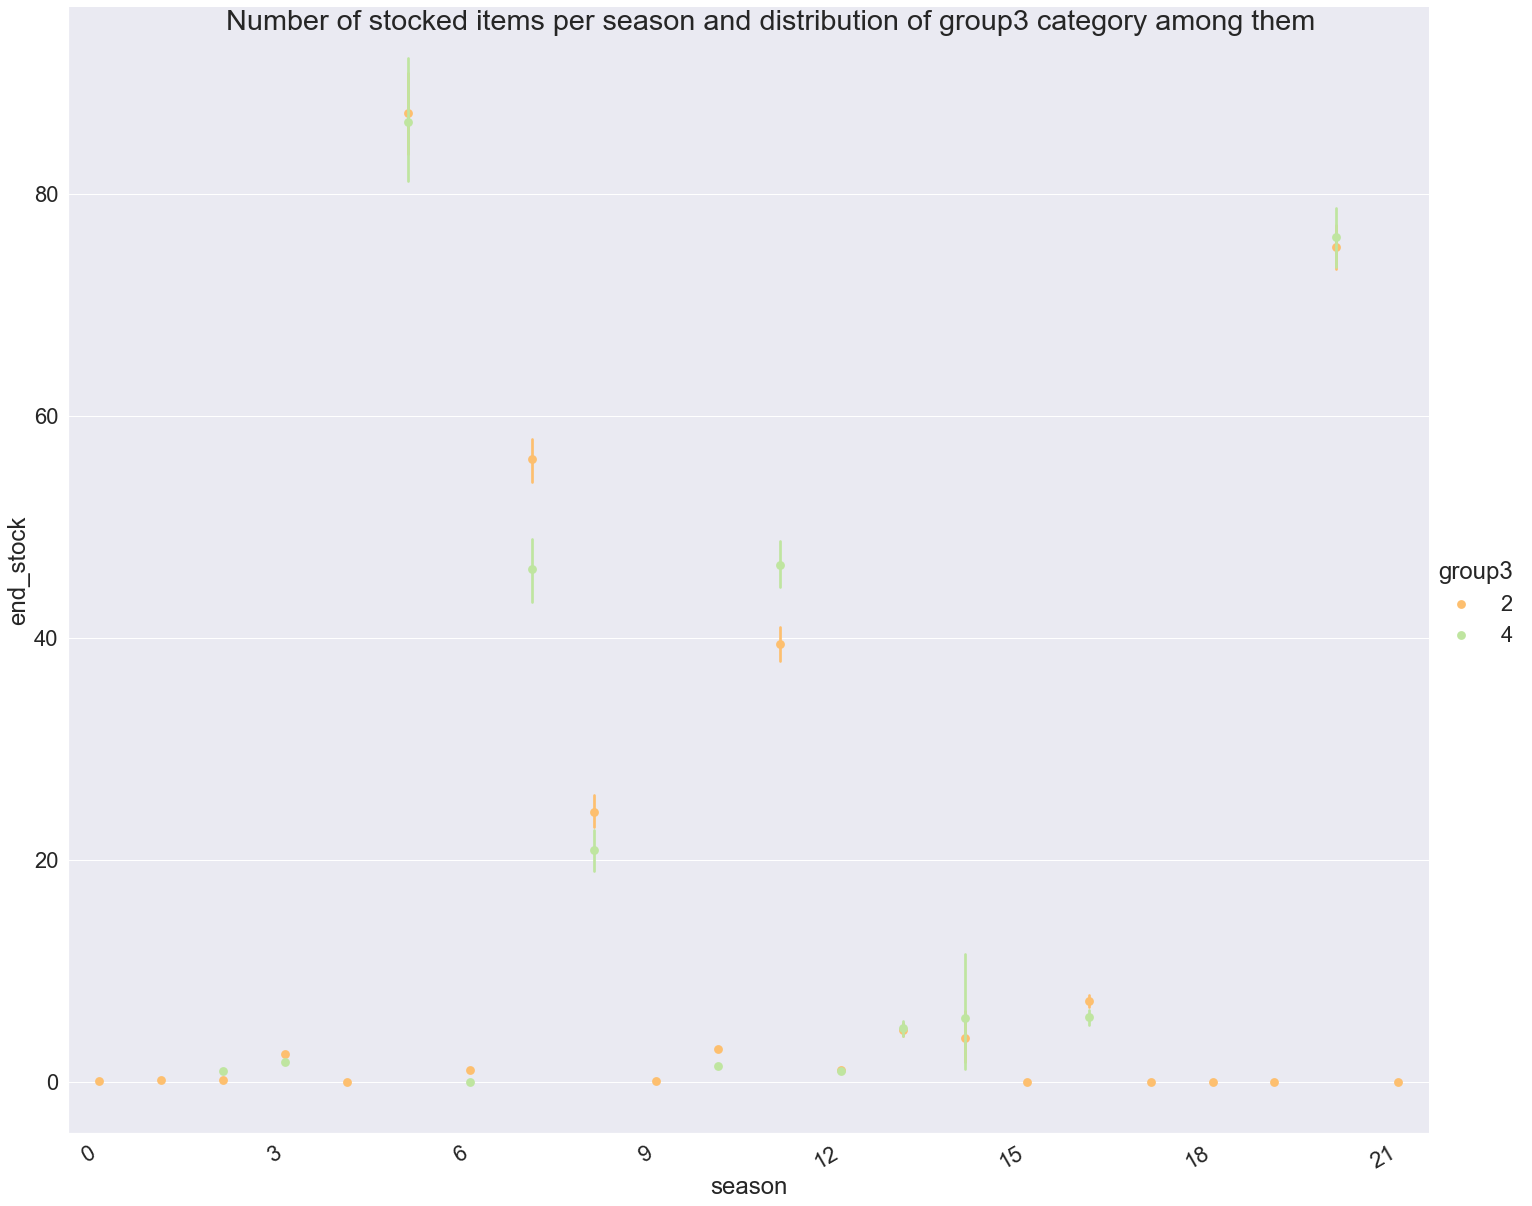

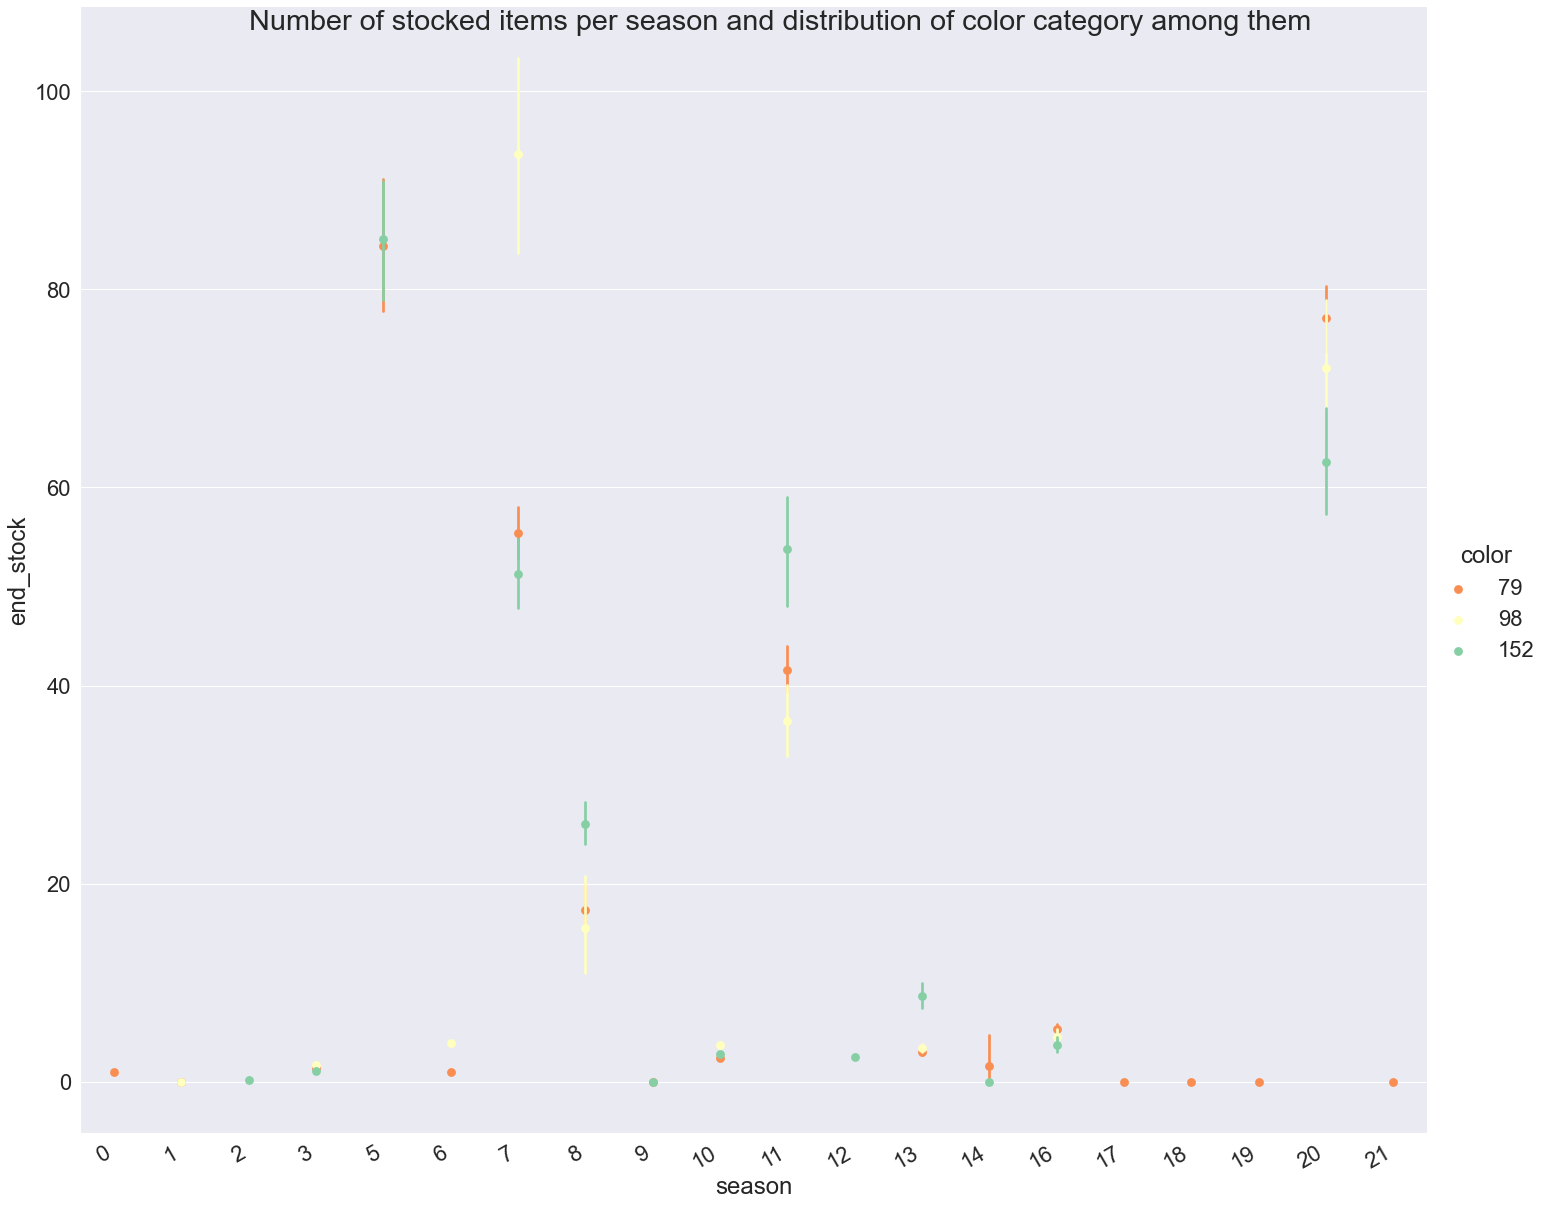

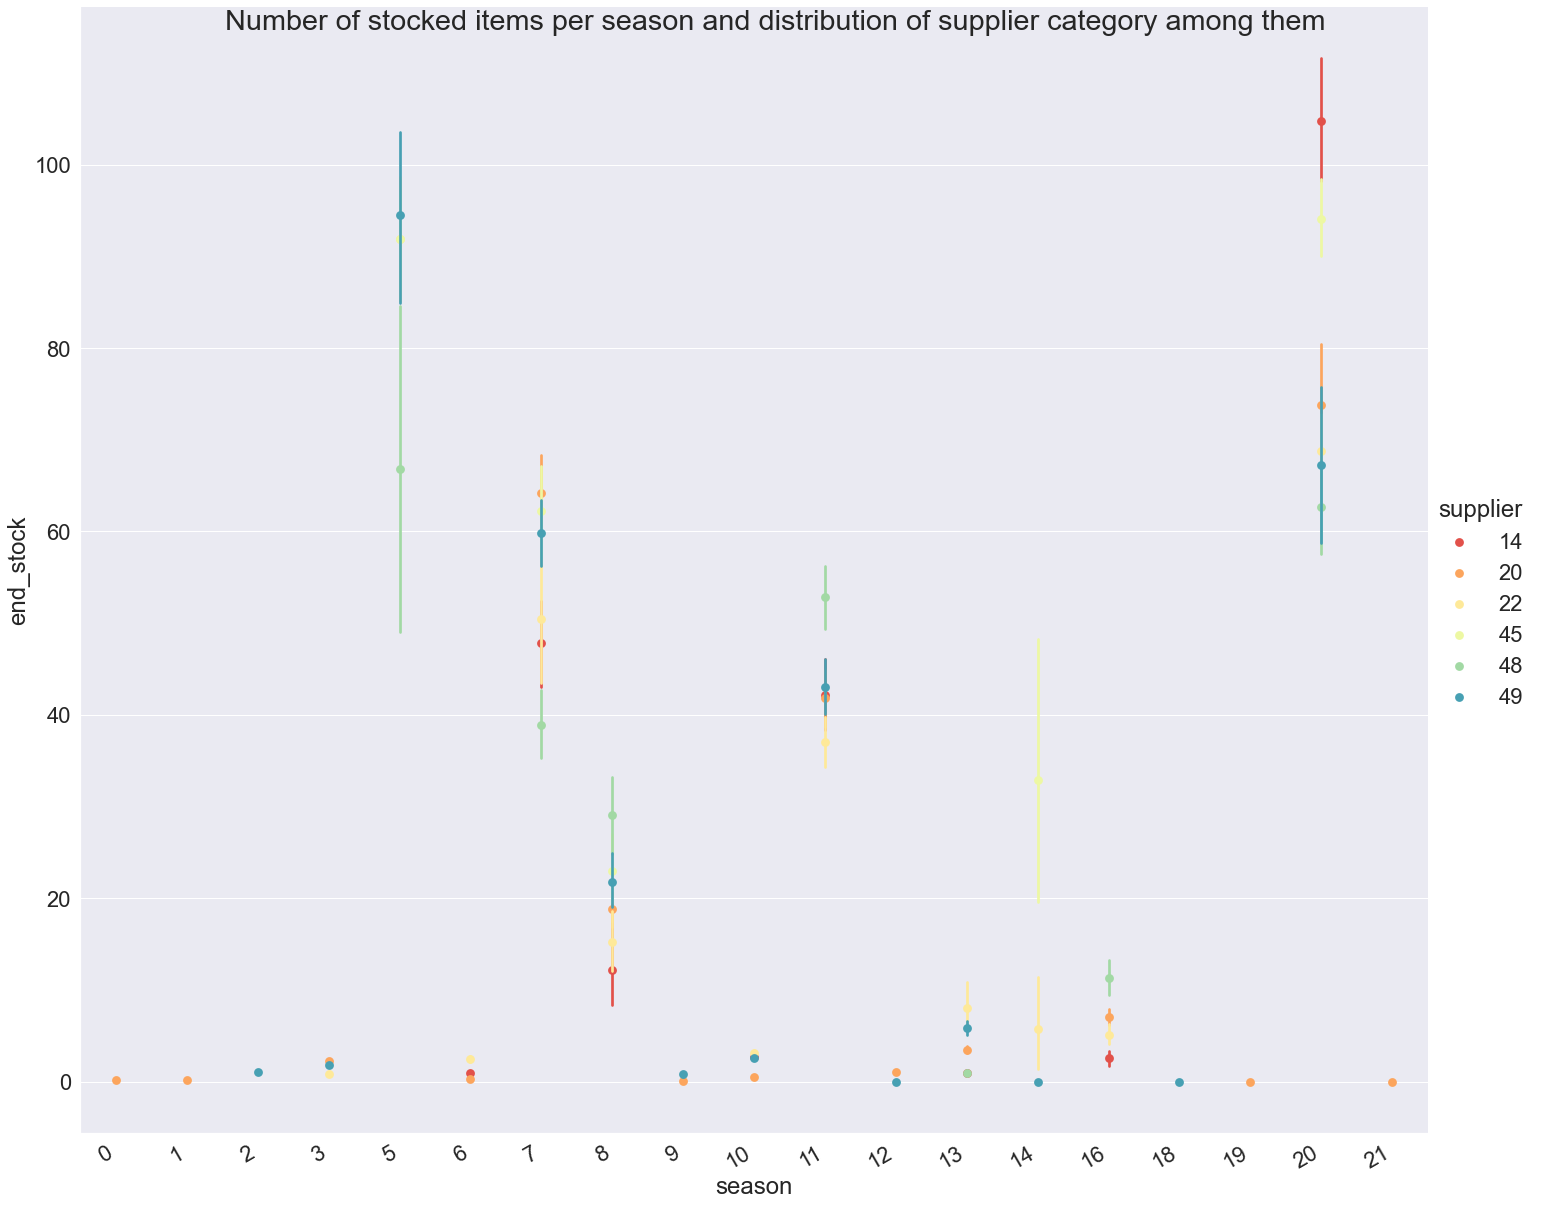

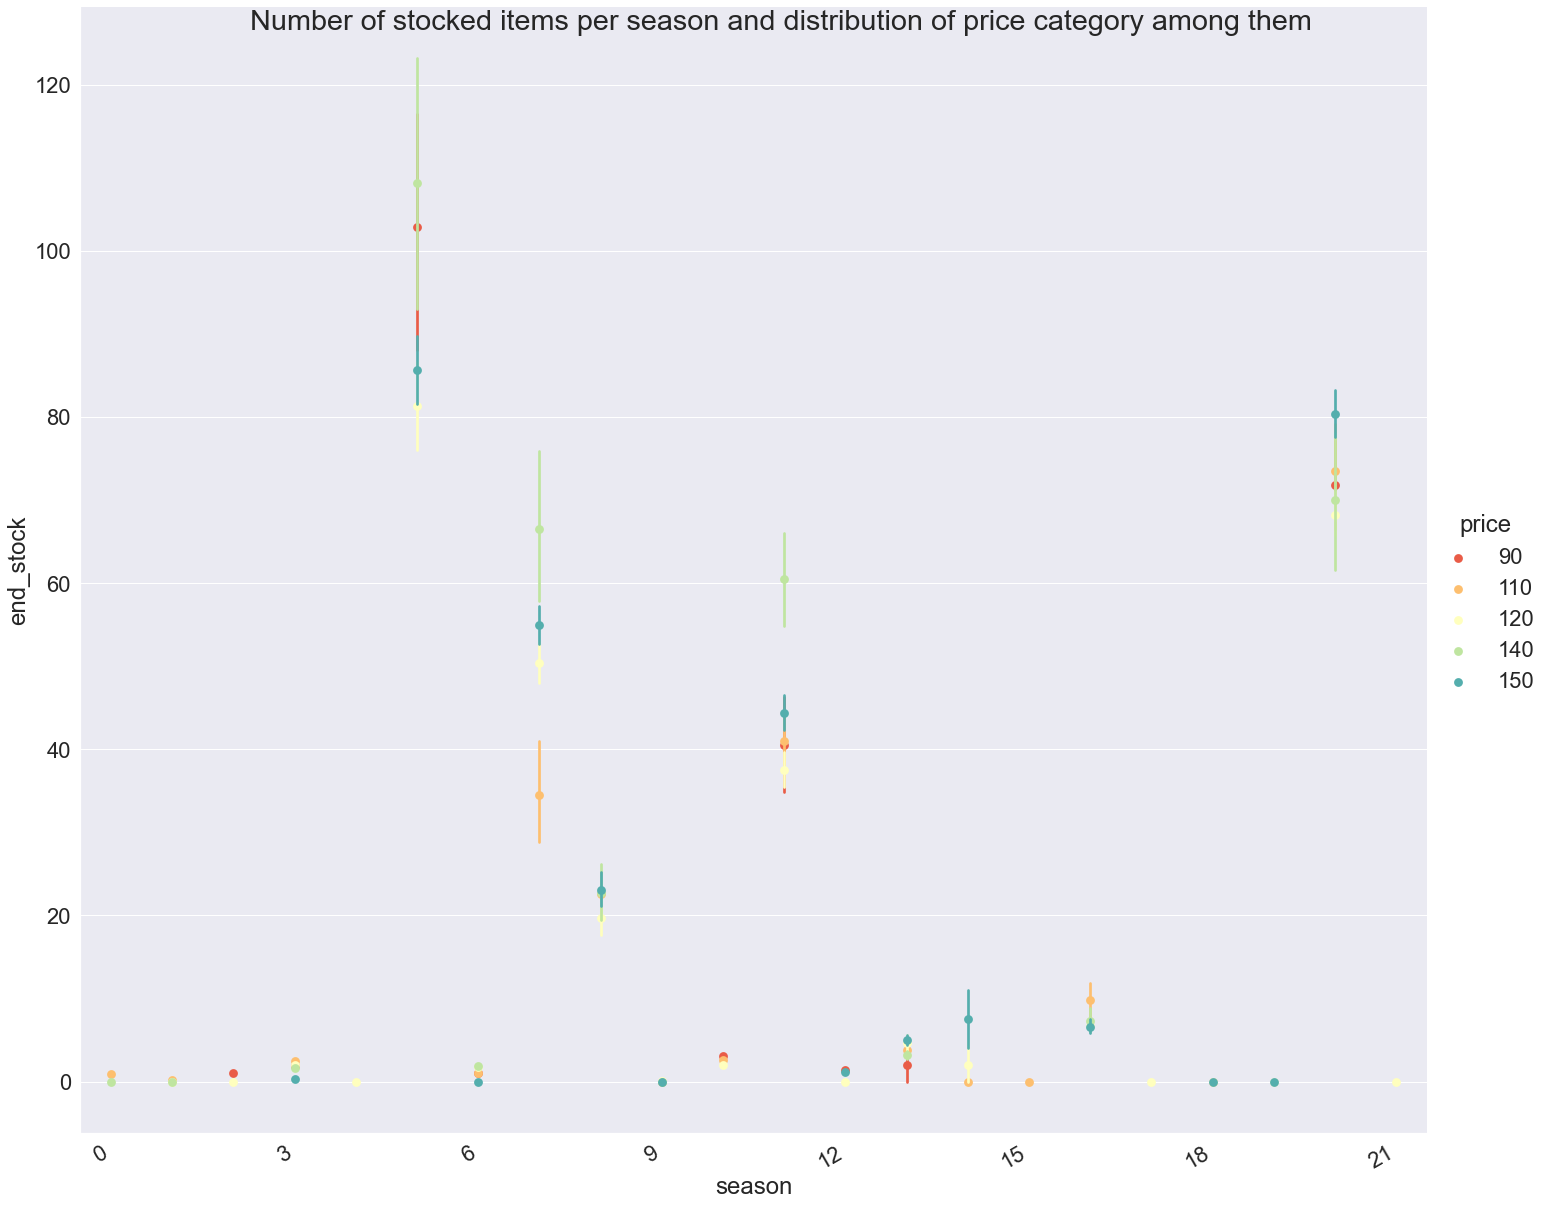

In [19]:
#plot seasonal invntory distribution base on different factors
features = ['group1', 'group2', 'group3', 'color', 'supplier', 'price']
for f in features:
    timeseries_distribution_ratio(df_a, f, 'end_stock', 'season')

These plots demonstrate the dynamic nature of inventory management and how certain characteristics and features of the most stocked items can vary depending on the season. By analyzing the data in this way, businesses can gain valuable insights into which items are in high demand during specific seasons and make informed decisions about how to allocate resources and manage their inventory.
For example, the plots may reveal that certain clothing items are more popular during the winter months, while outdoor equipment sees a spike in sales during the summer. This information can inform decisions on when to restock items, which items to discount, or even which items to discontinue.
Furthermore, the use of different hue in the plots can also show how different features of the items are affected by the season, such as color, size or brand. This can help businesses to identify trends and preferences of their customers based on the season which can be used in their marketing strategies.
In short, these plots provide a visual representation of how seasonal changes can impact a business's inventory, and can be a valuable tool for inventory management and decision making.

C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update

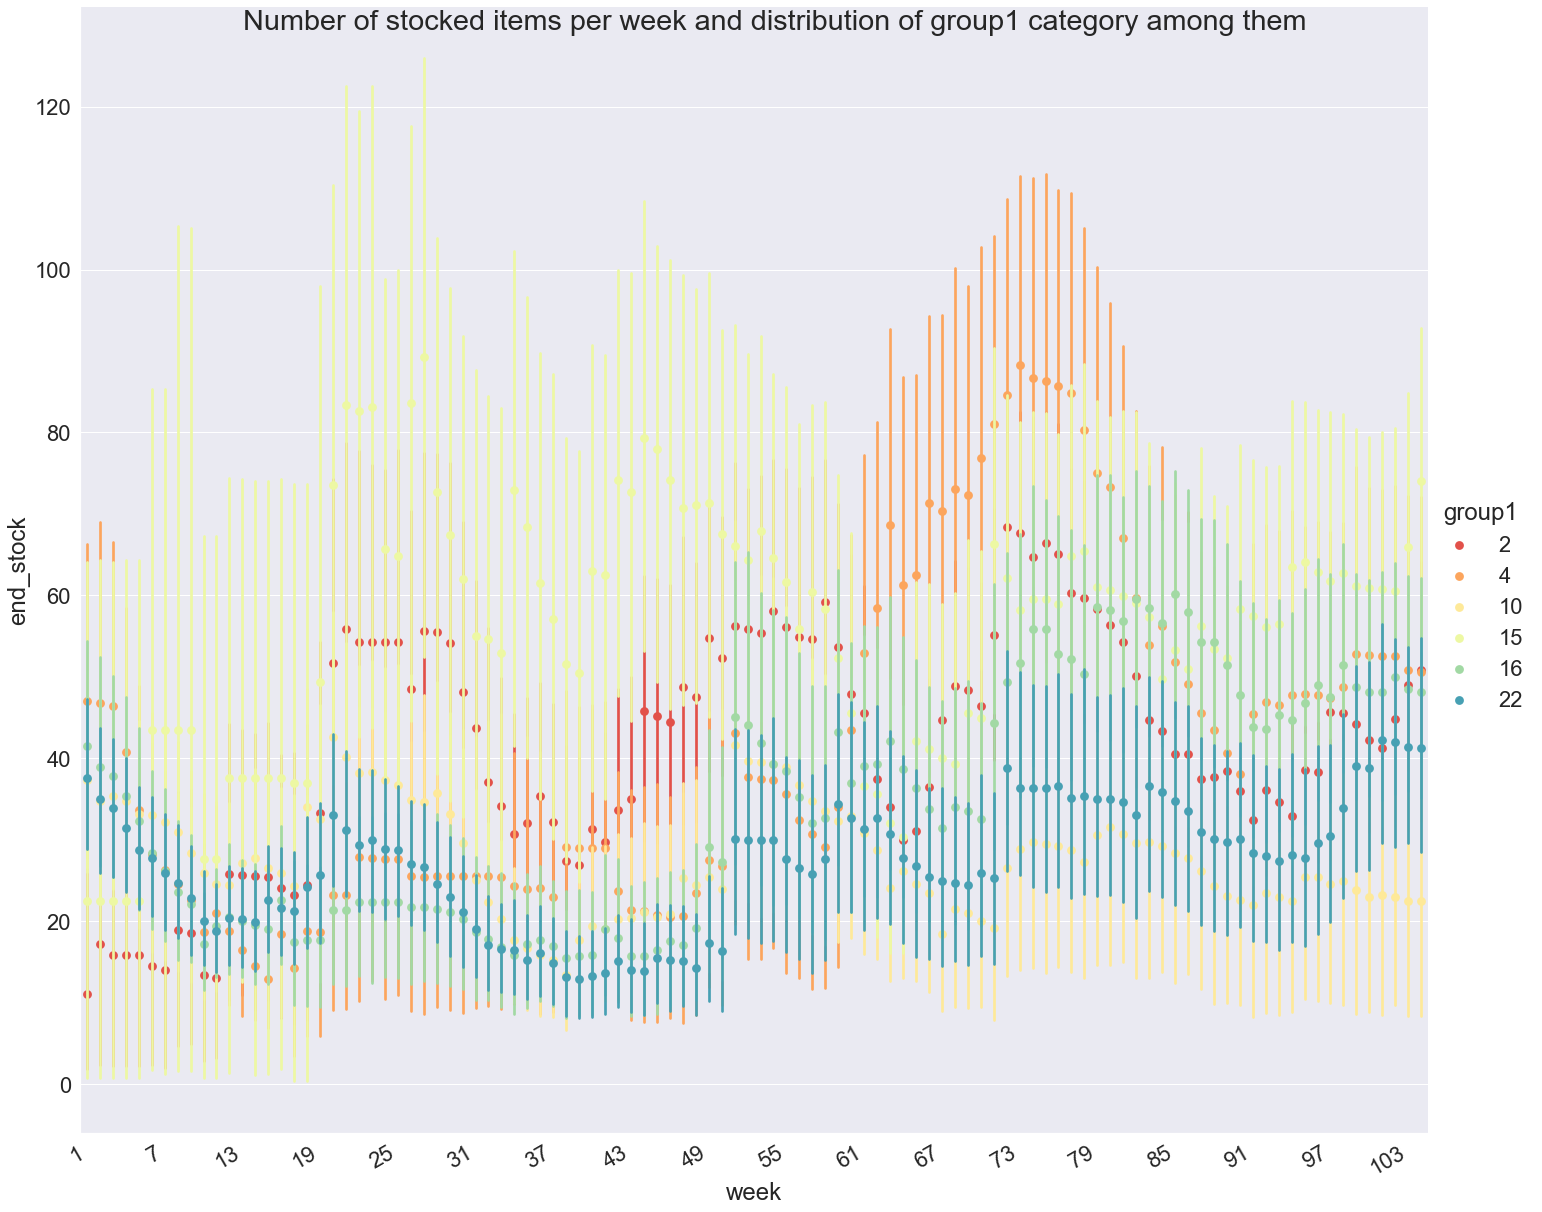

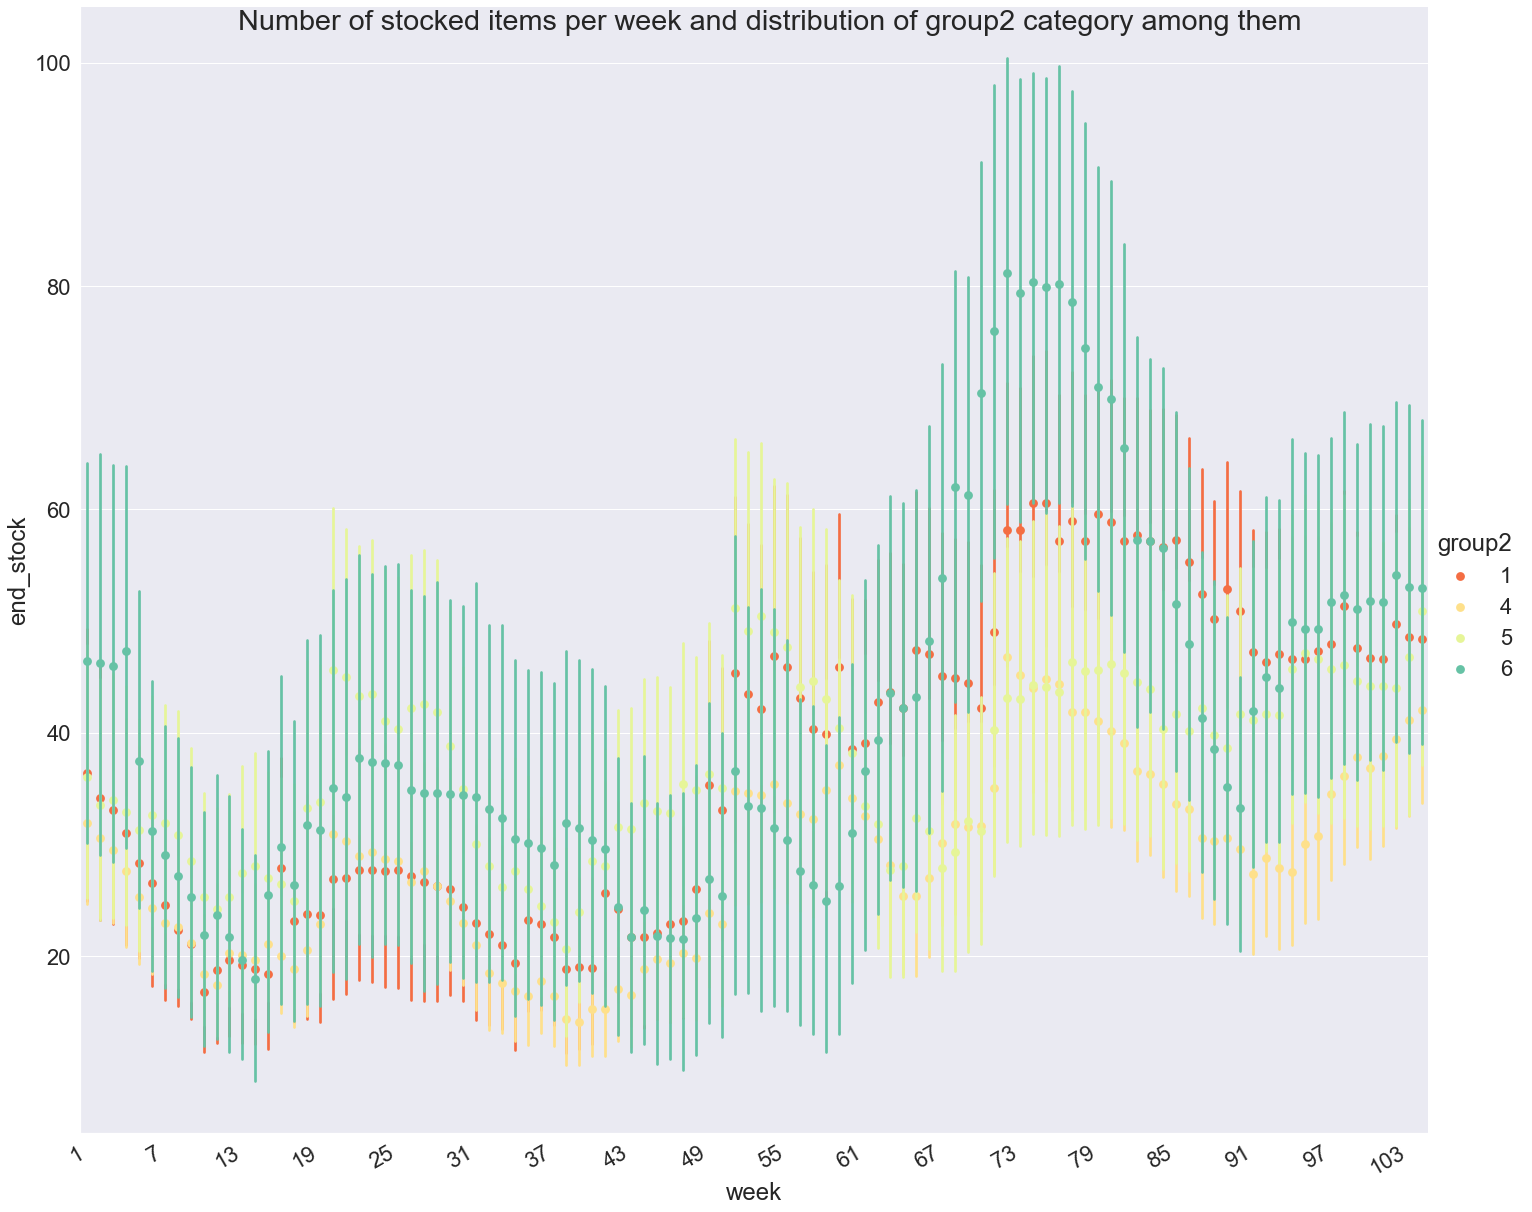

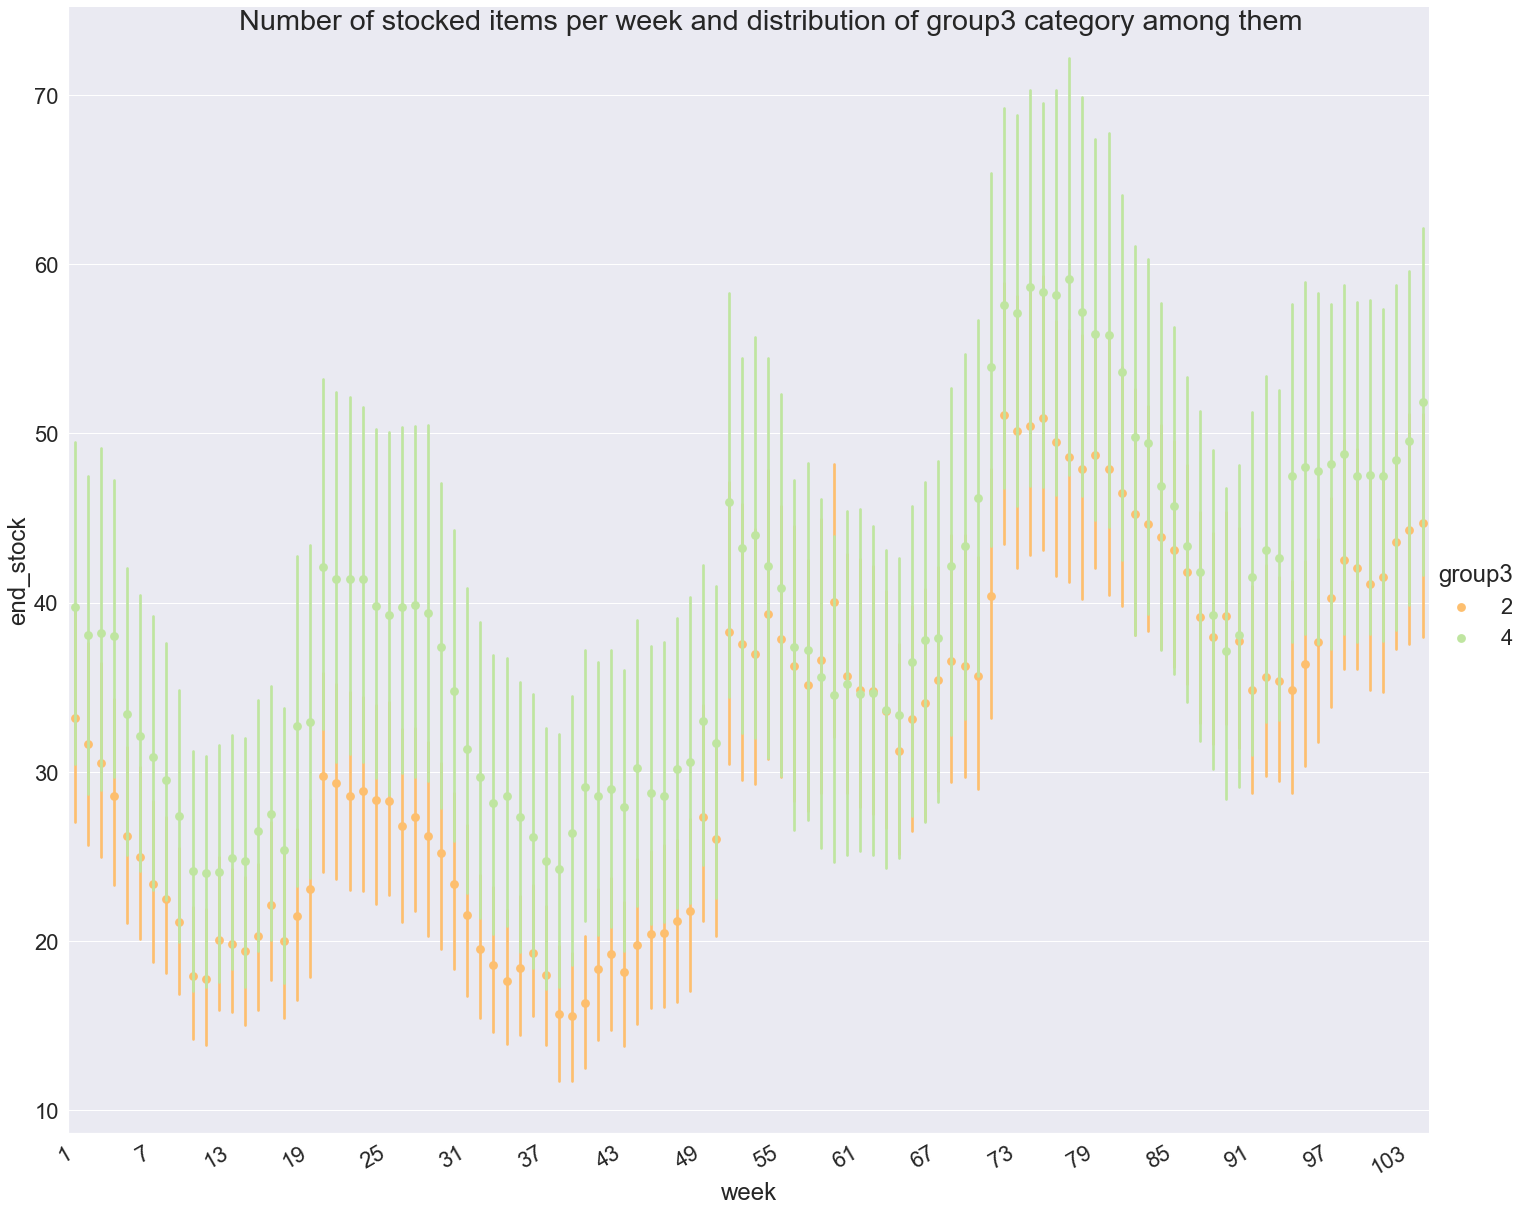

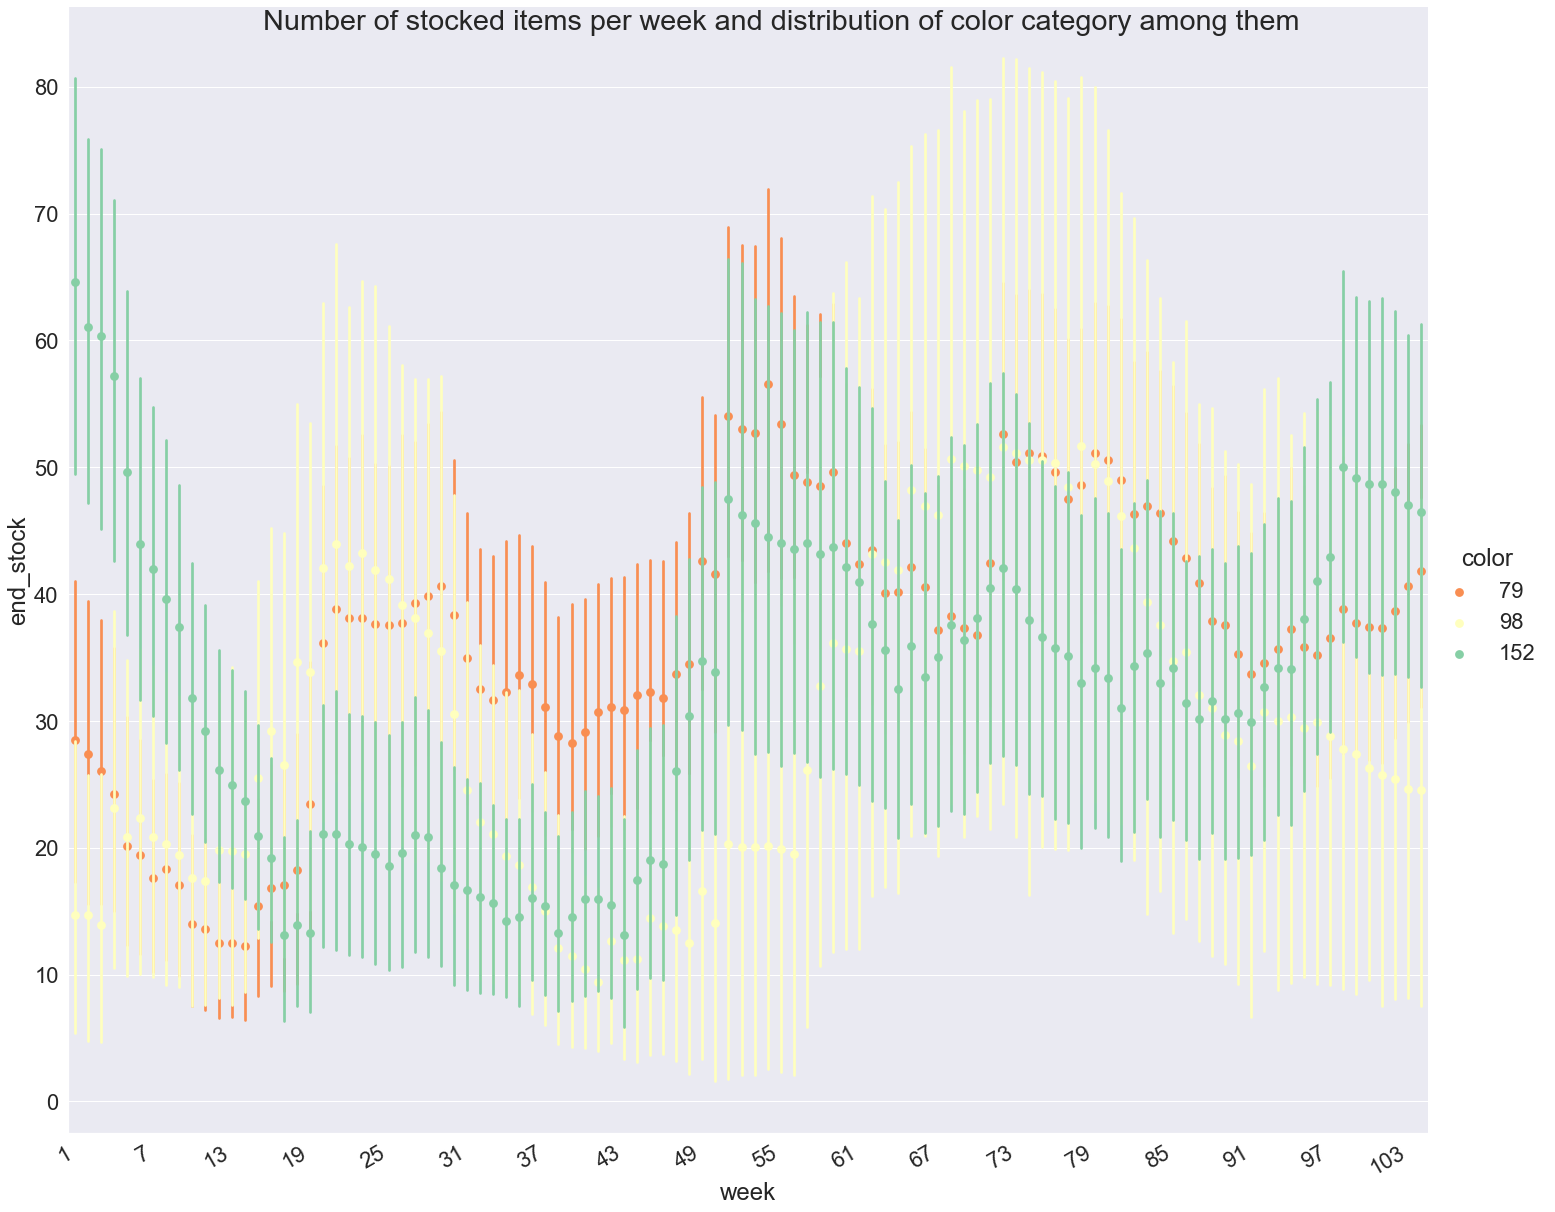

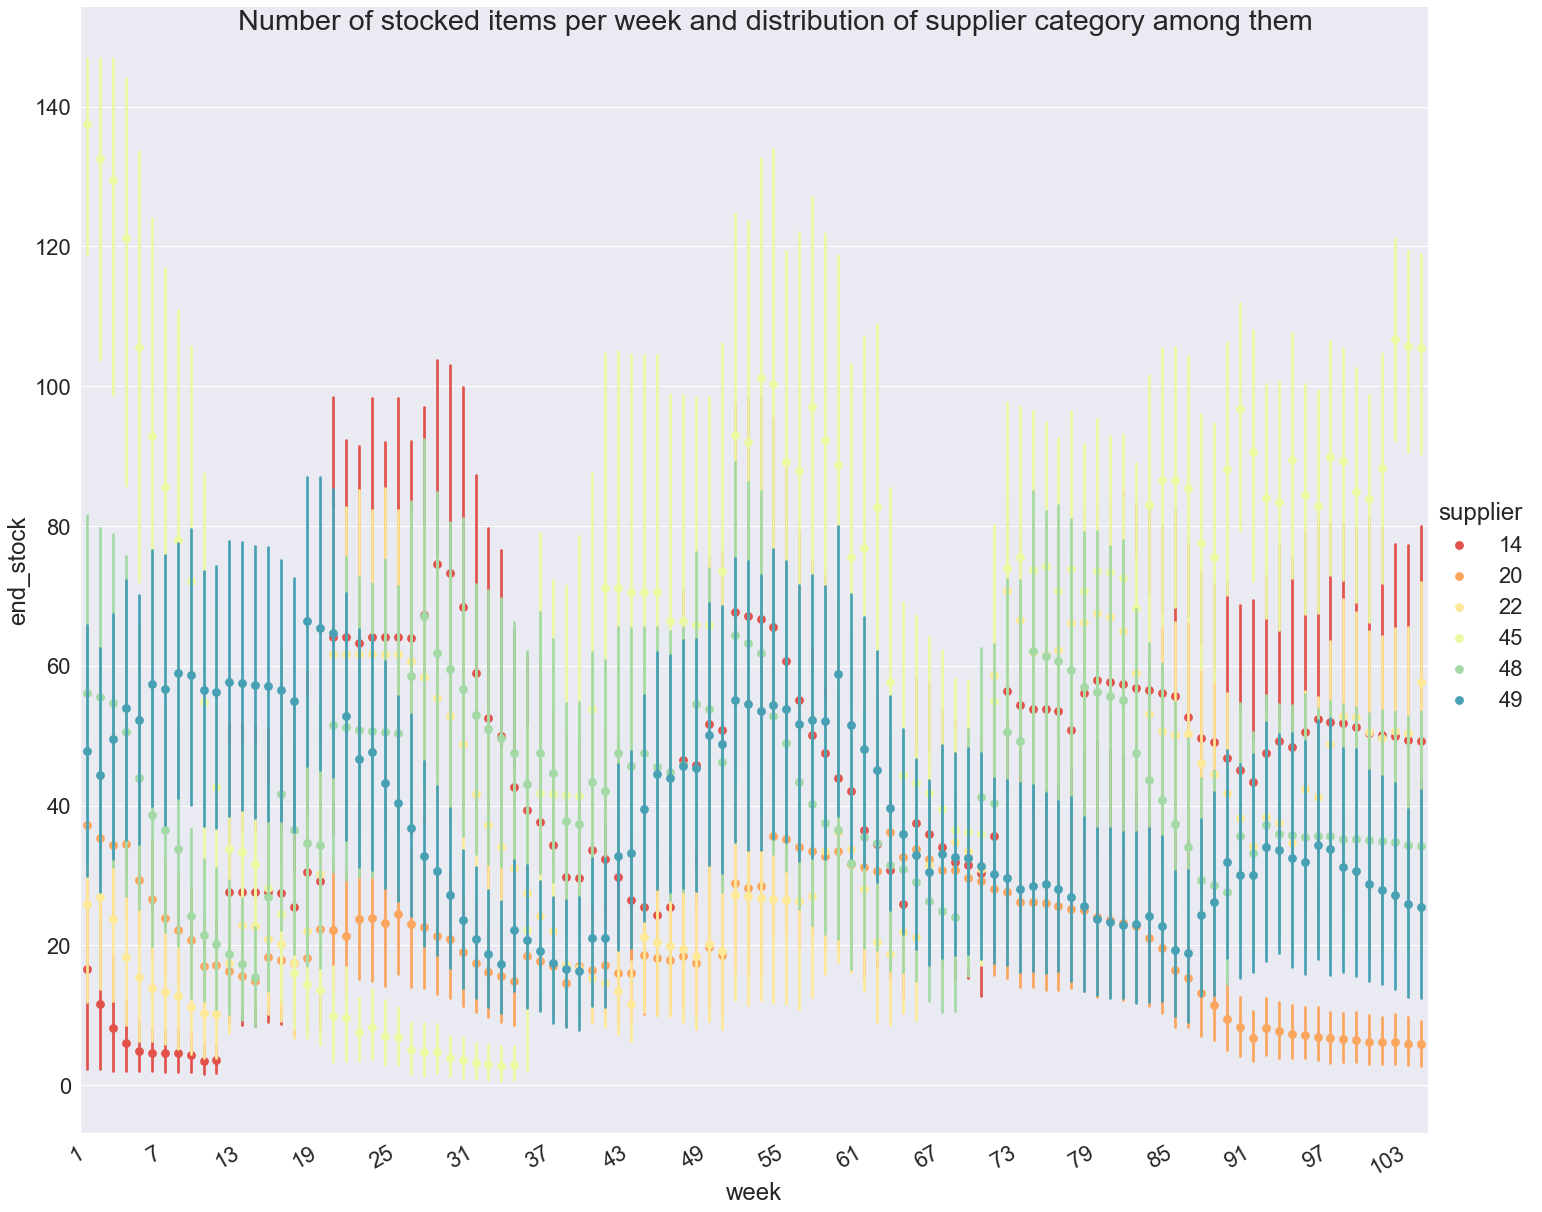

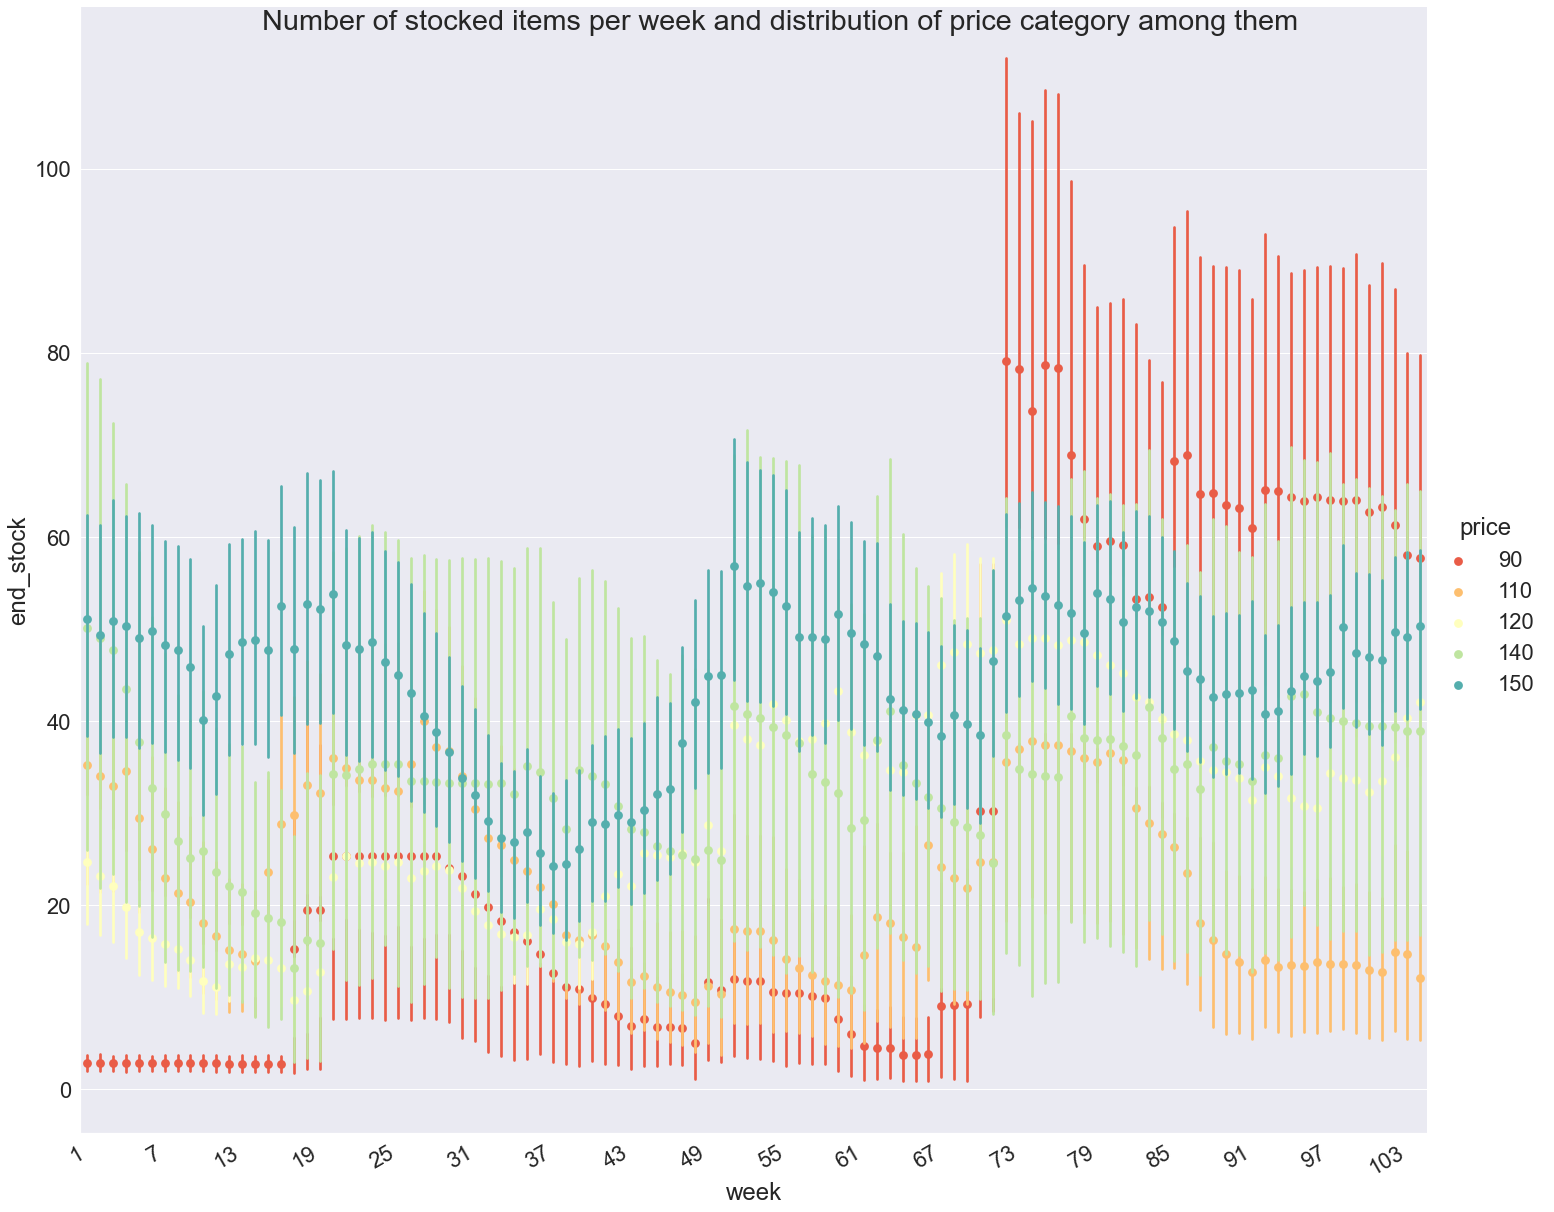

In [20]:
#plot weekly invntory distribution base on different factors
for f in features:
    timeseries_distribution_ratio(dataframe=df_a, feature=f, target='end_stock', time='week')

The analysis of inventory patterns over time can present a different perspective than analyzing data by season. While the patterns may not be as distinctive as seasonal analysis, looking at the plot of the past few weeks can still provide useful information about inventory management. This can help businesses to identify short-term trends and patterns that may not be as apparent when looking at data over a longer period of time.

Furthermore, it can be concluded that the number of cheap items (like red) drops much faster than the higher end of the price range (like blue) as seen in the plots. This could be due to a variety of factors such as consumer behavior or market conditions. Businesses can use this information to make informed decisions about pricing strategies, product development, and inventory management.

Additionally, the plot for higher end items (like blue) shows a much more flat curve, indicating a more stable demand for these items. This could be attributed to the fact that these items are considered luxury items, and consumers may be more willing to spend more money on them, resulting in a more stable demand. This information can be used to inform the business's marketing and sales strategies.

### Analysis of Sale Data

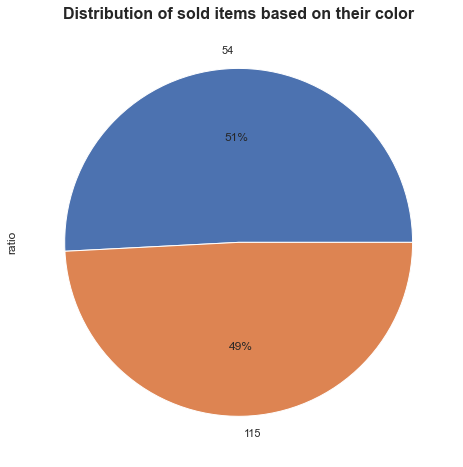

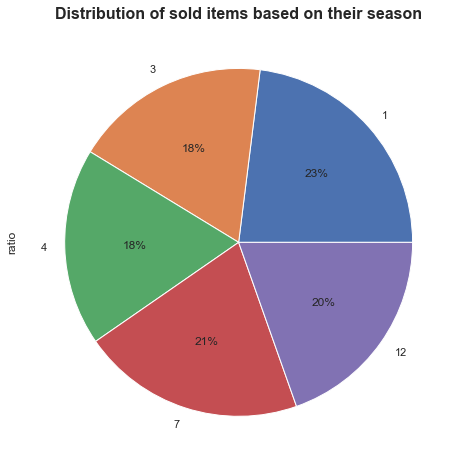

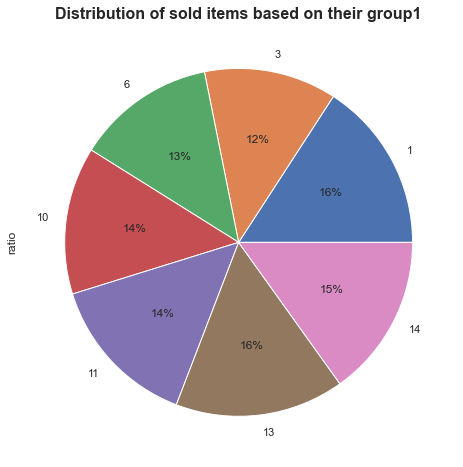

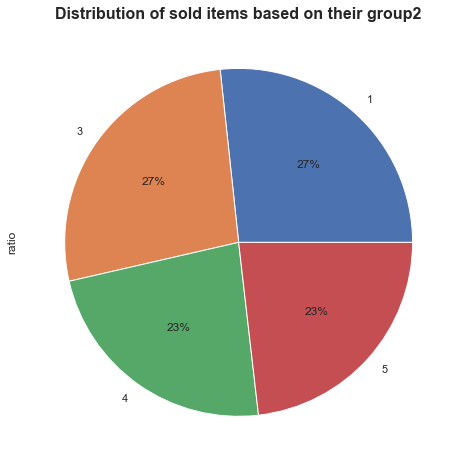

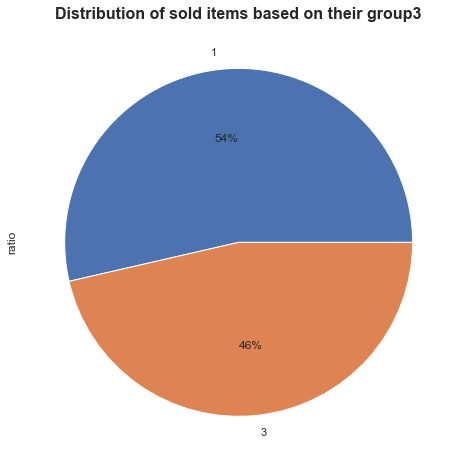

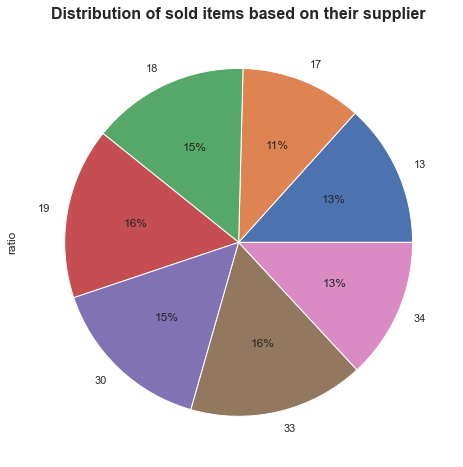

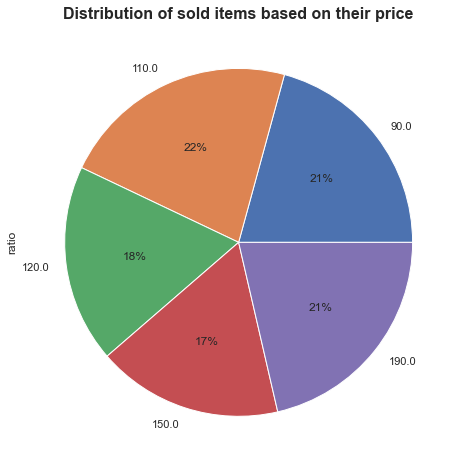

C:\Users\V\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1841: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


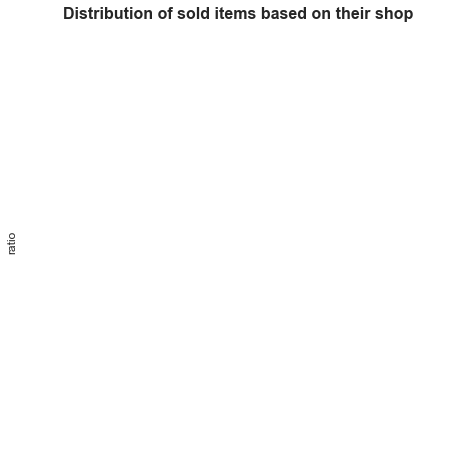

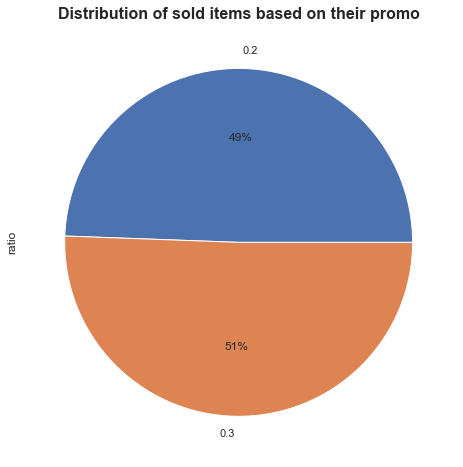

In [21]:
features = [
    'color', 'season', 'group1', 'group2', 'group3', 'supplier', 'price',
    'shop', 'promo'
]
#plot the ratio of the sold items per feature based on the frequency of that feature in the dataframe
for f in features:
    plot_distribution_ratio(df_b, f, 'sold')

C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update

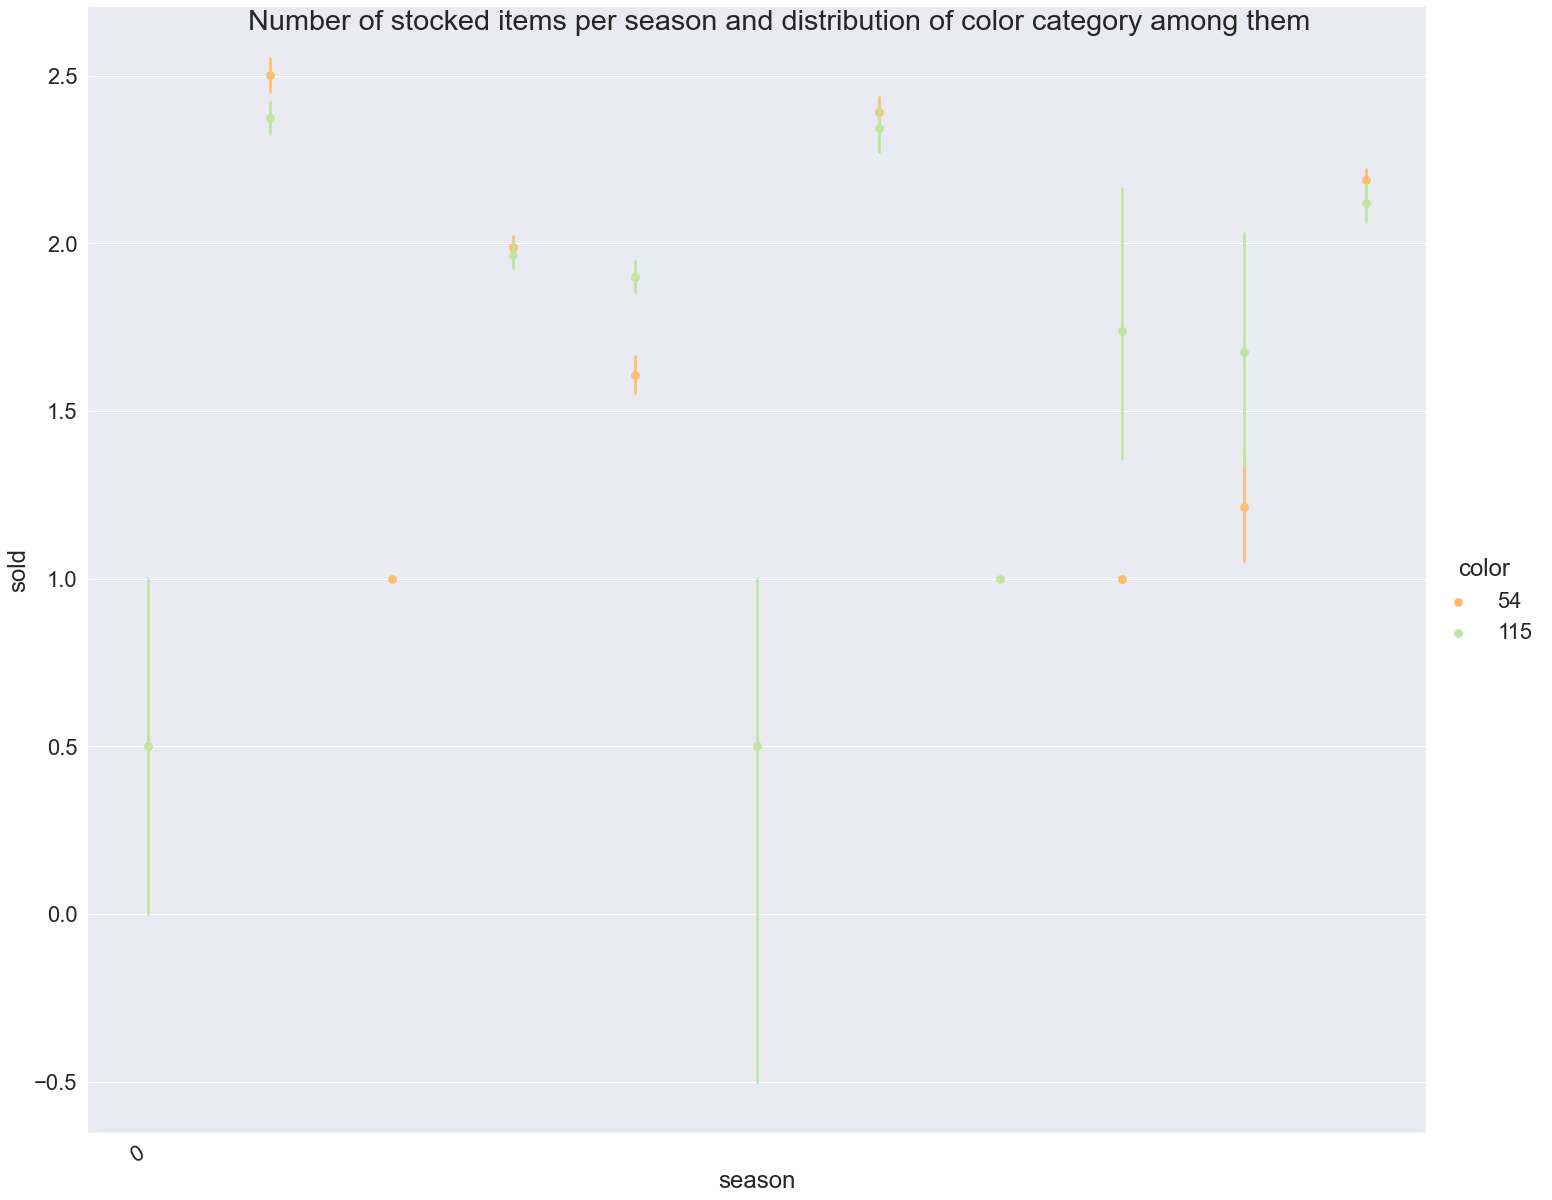

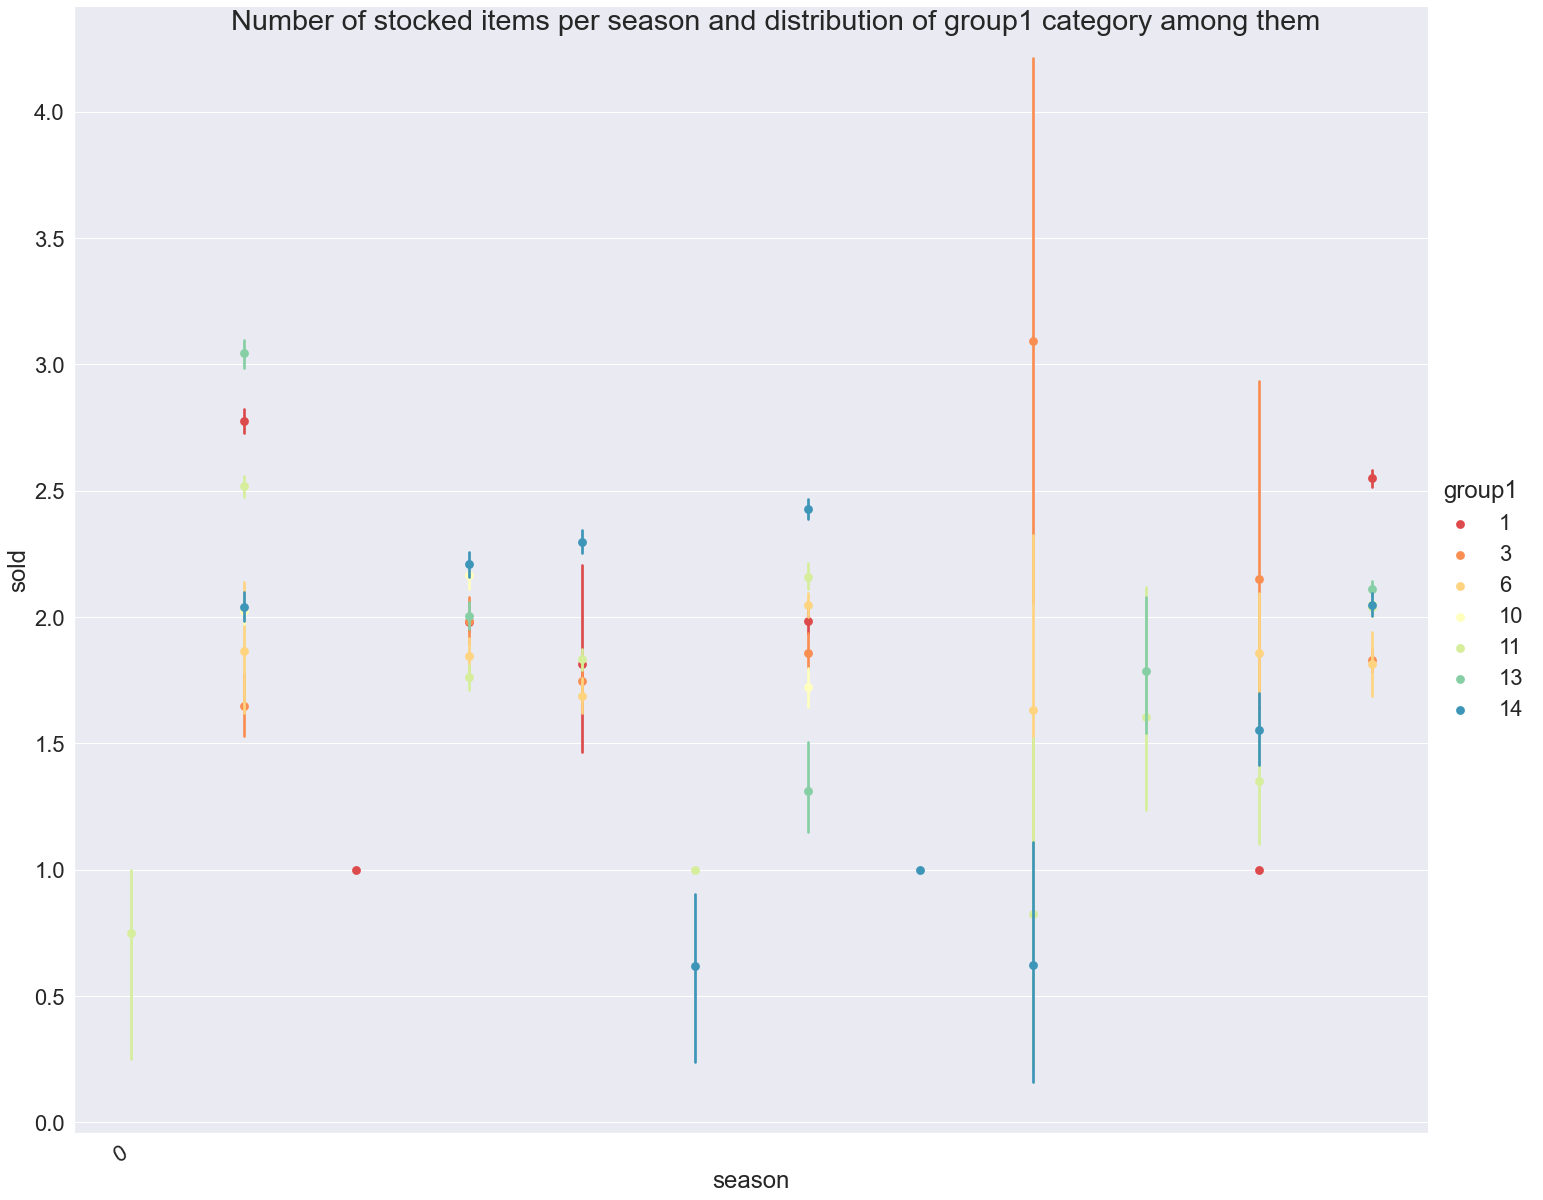

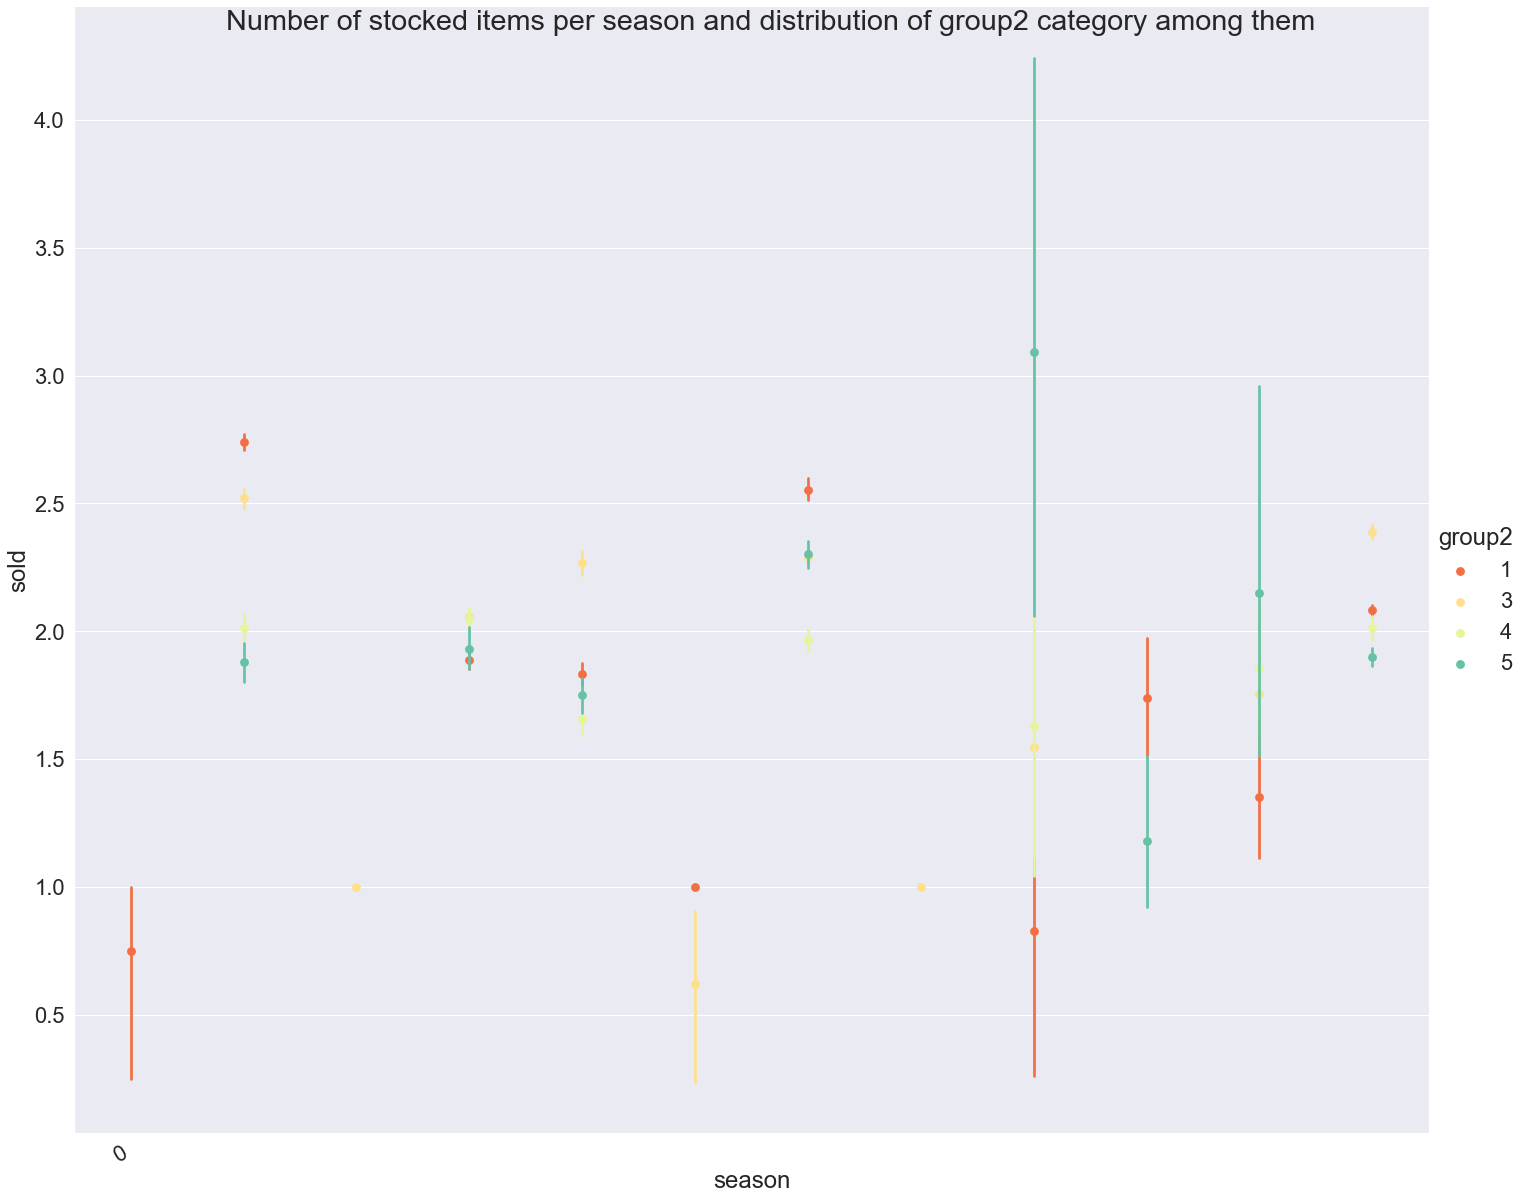

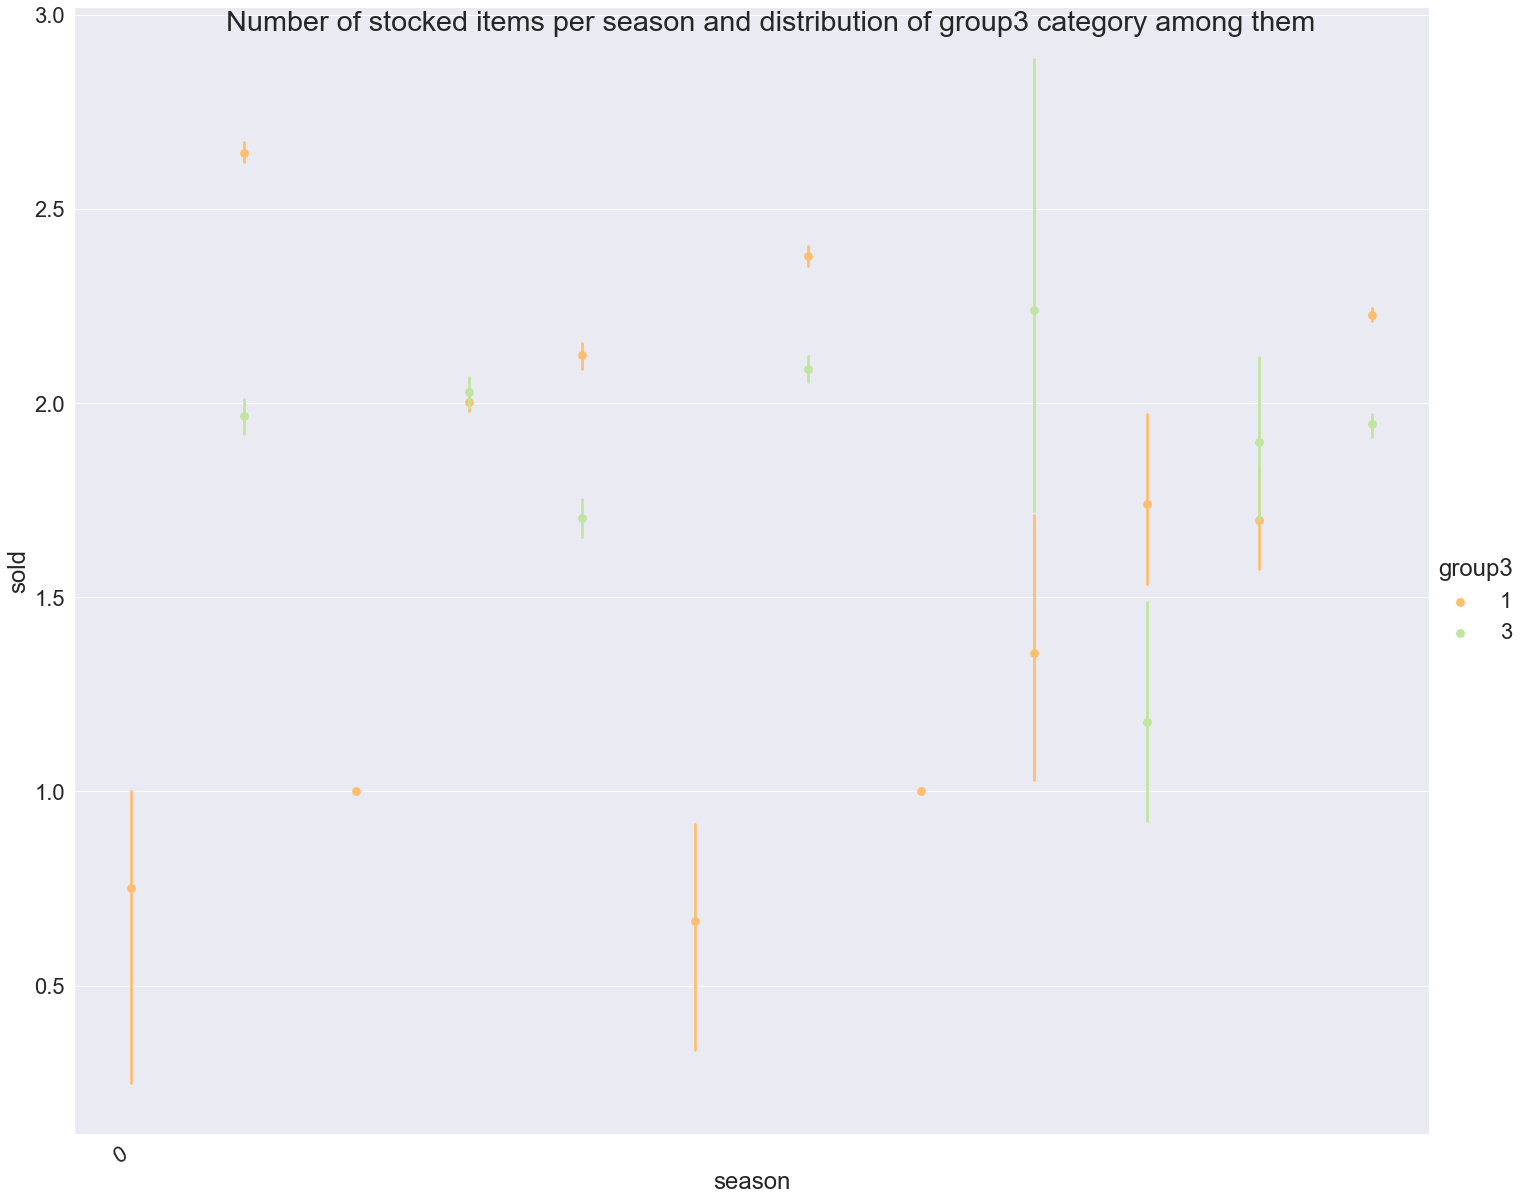

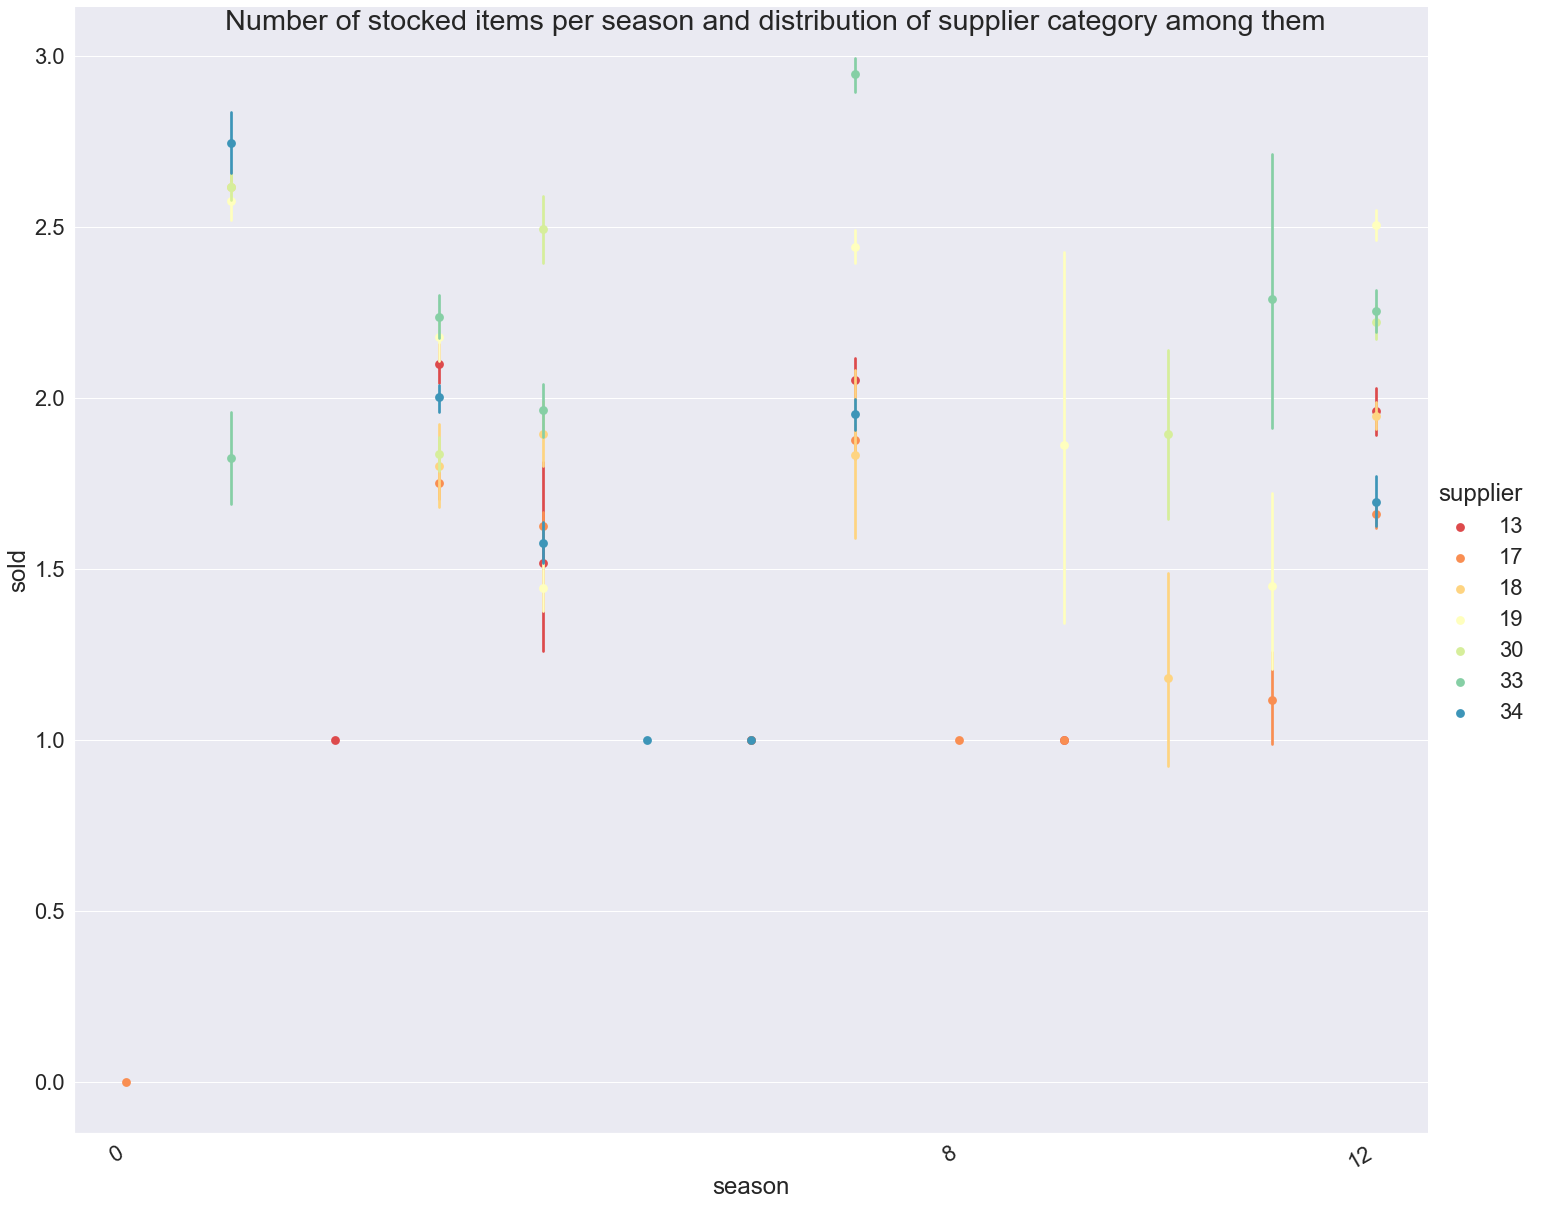

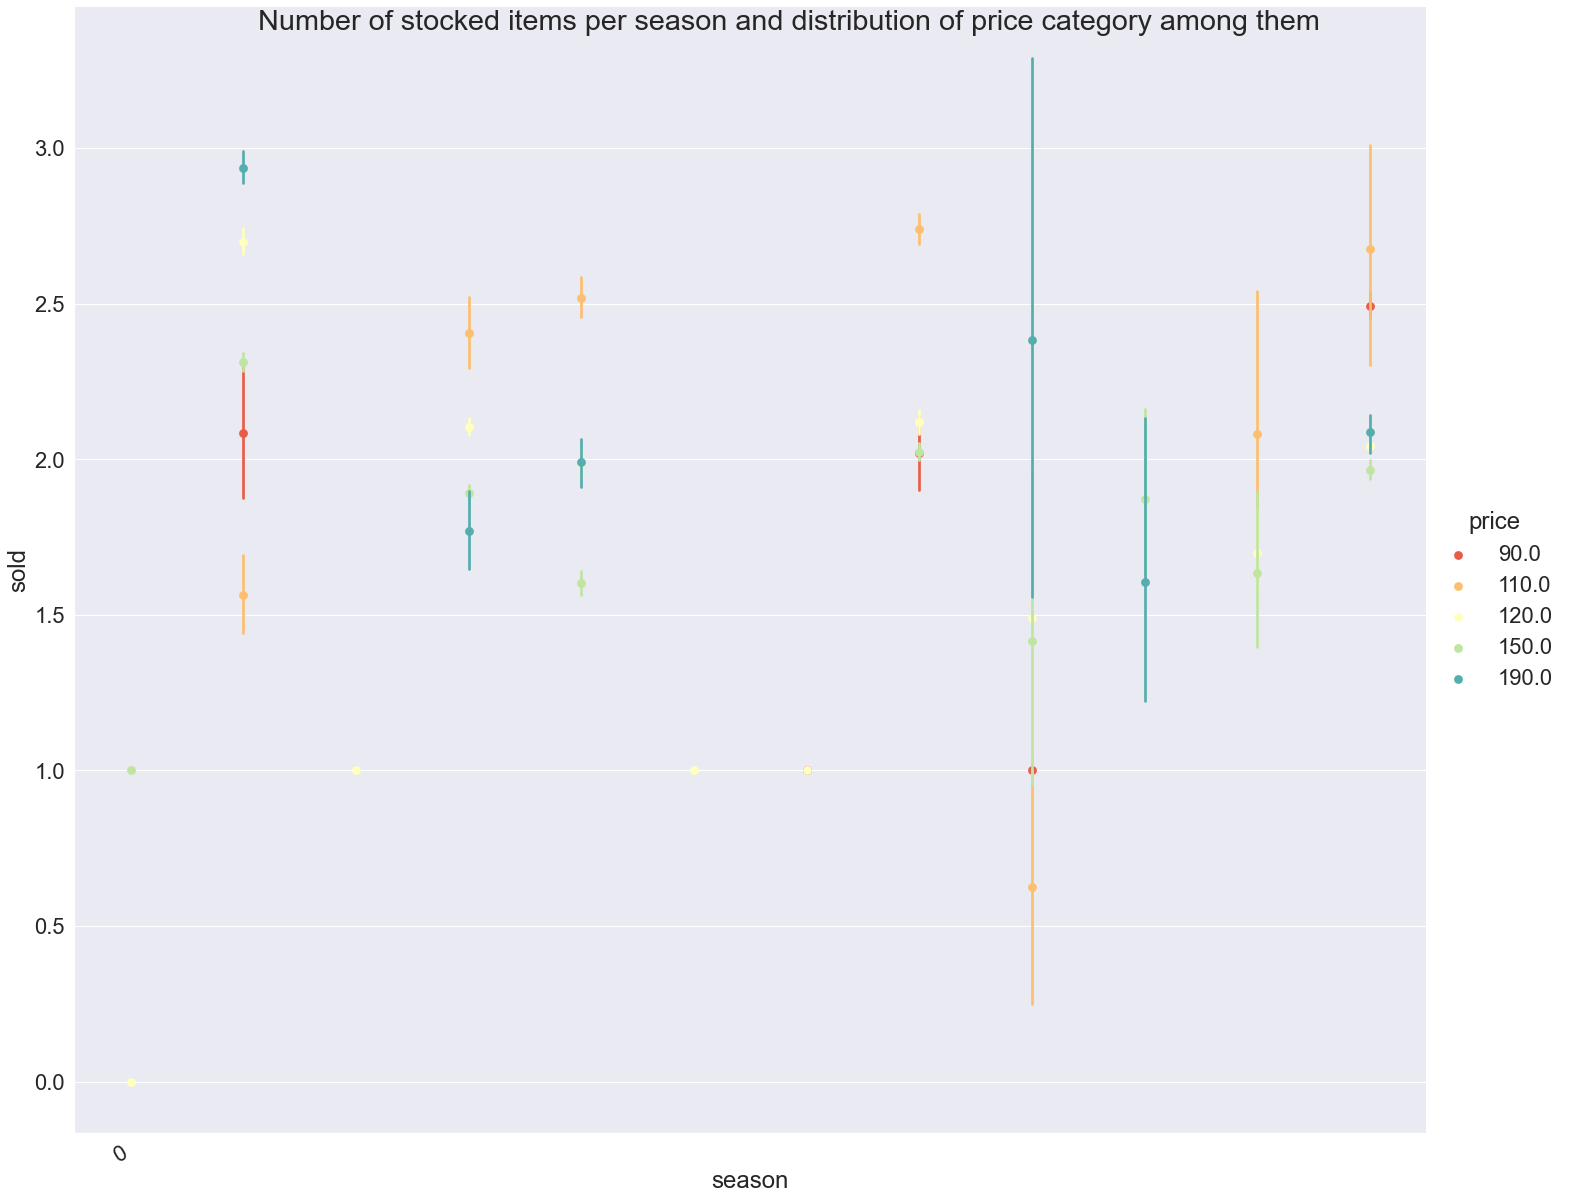

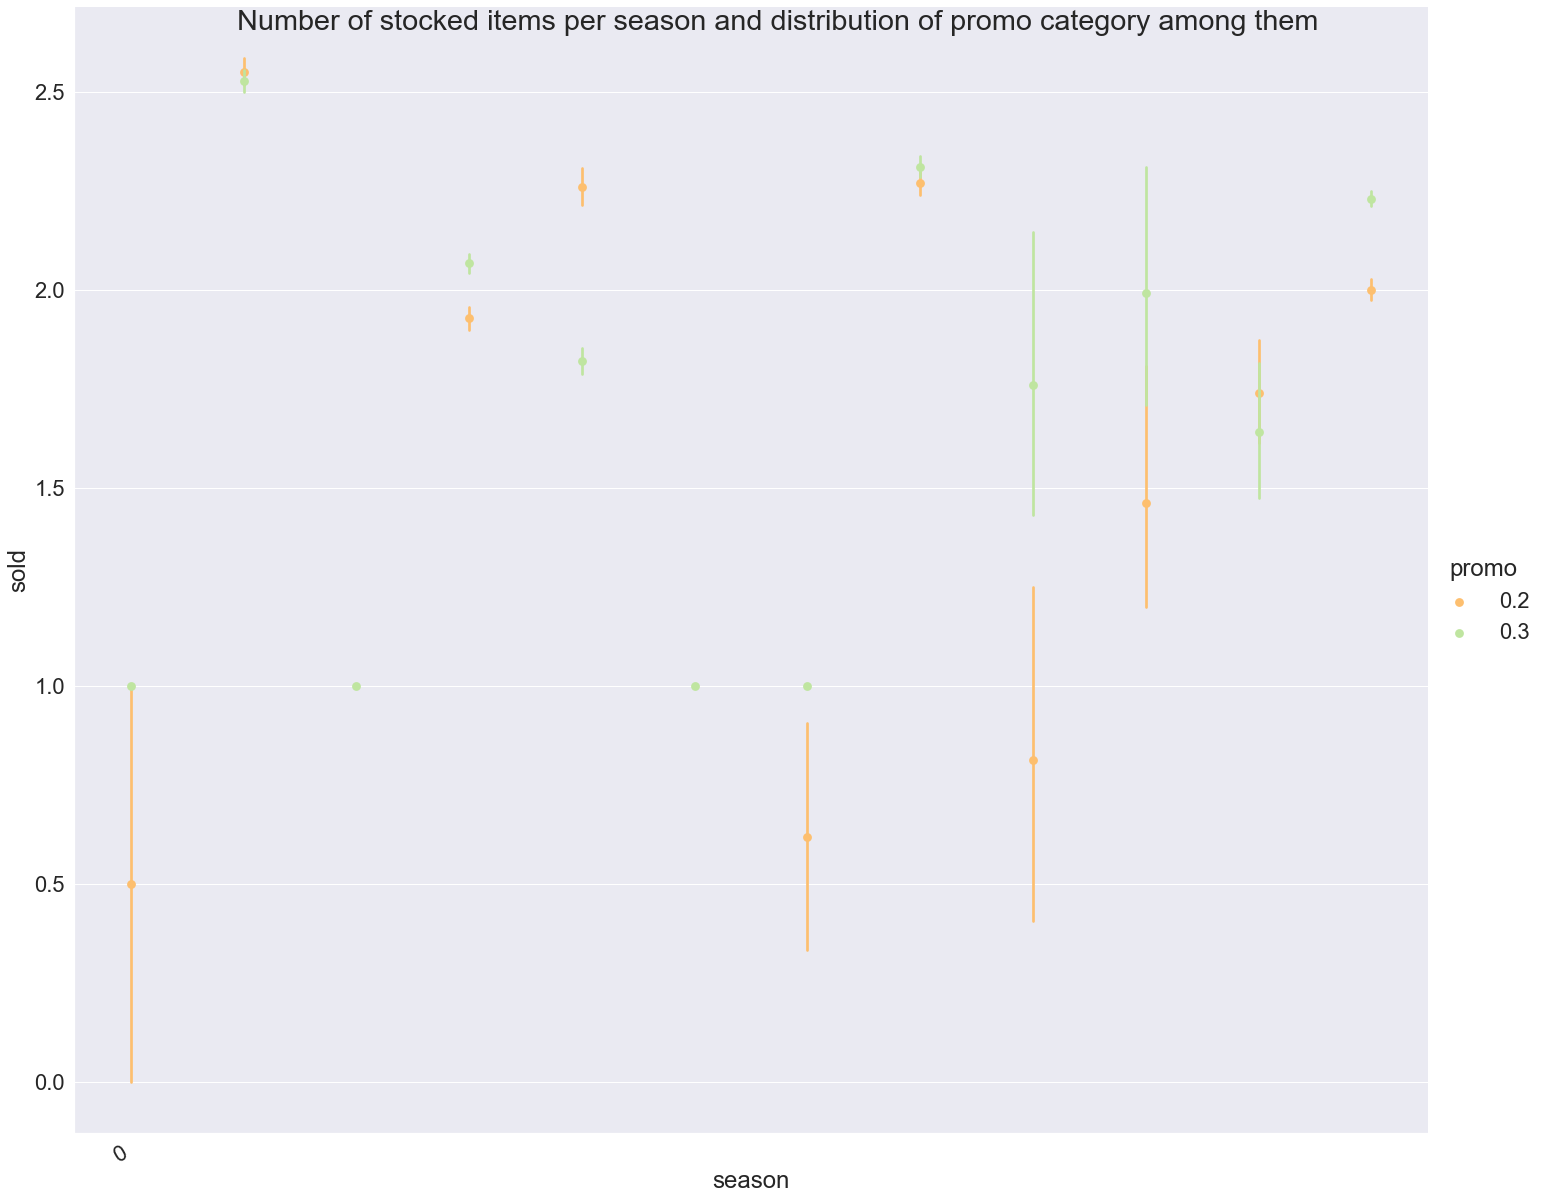

In [23]:
#plot seasonal sale distribution base on different factors
features = [
    'color', 'group1', 'group2', 'group3', 'supplier', 'price', 'promo'
]
for f in features:
    timeseries_distribution_ratio(dataframe=df_b, feature=f, target='sold', time='season')

C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\V\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update

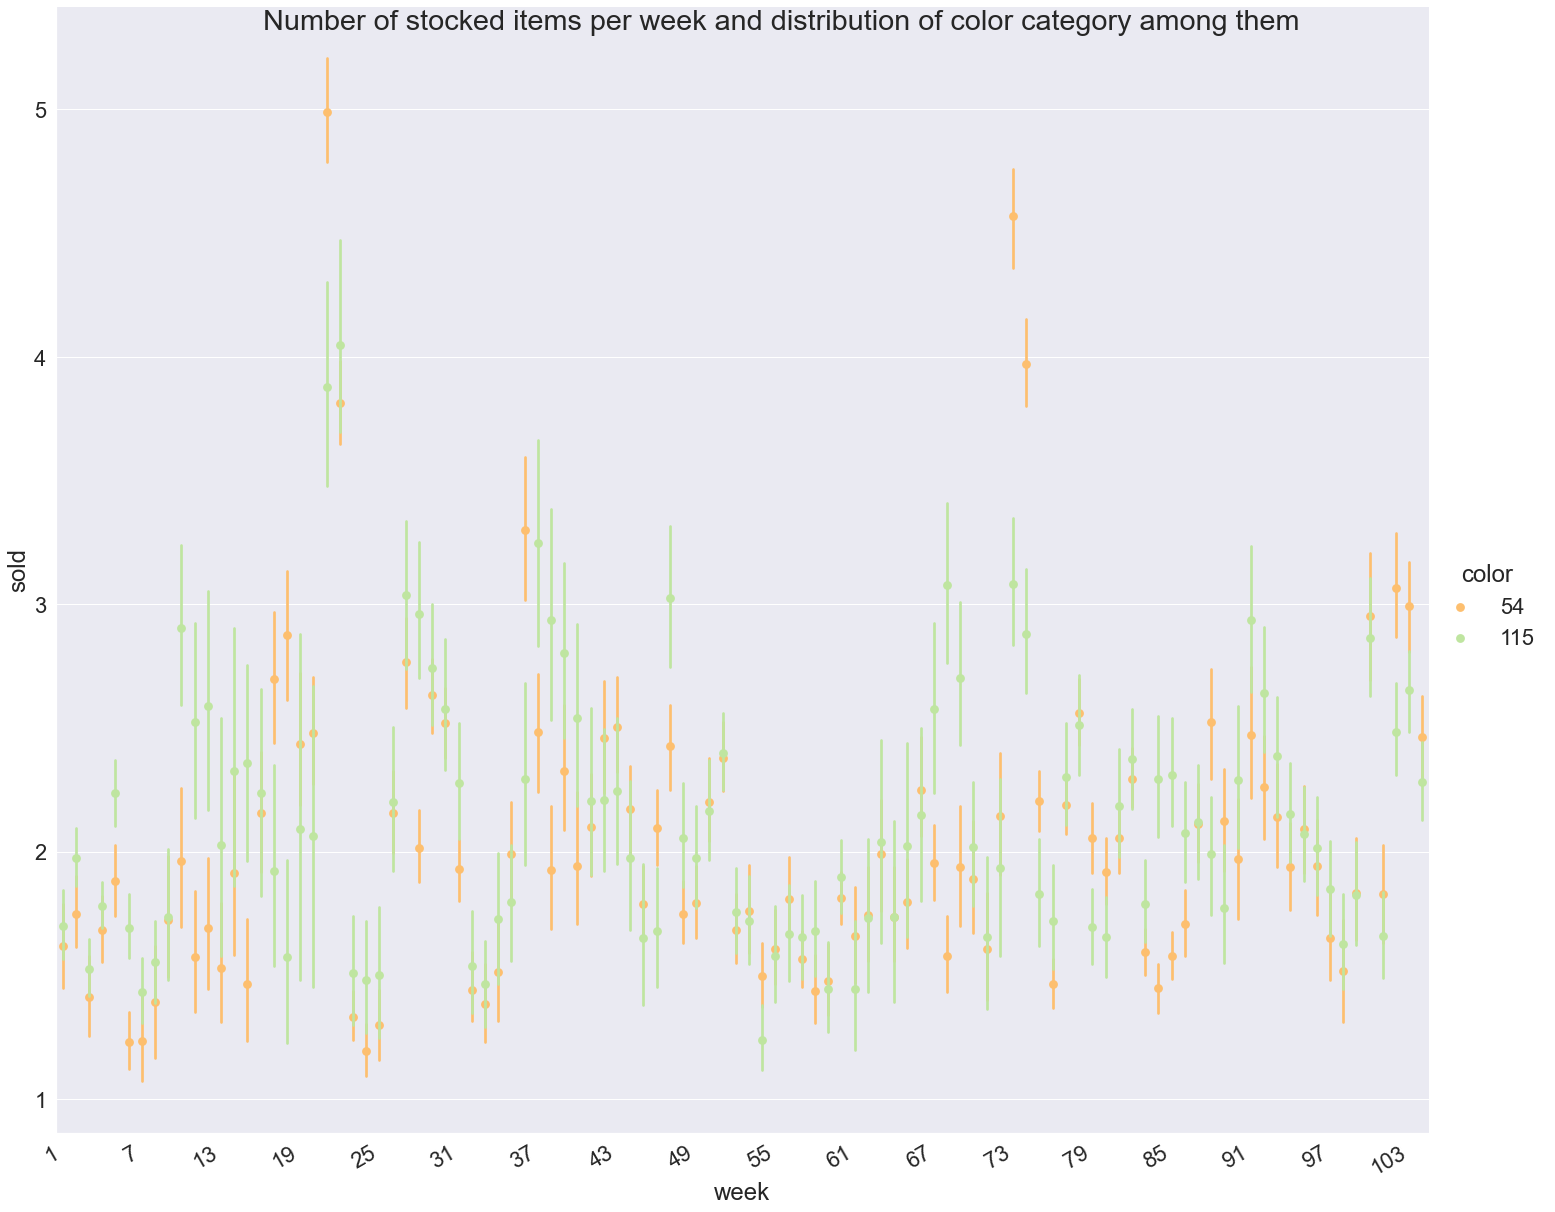

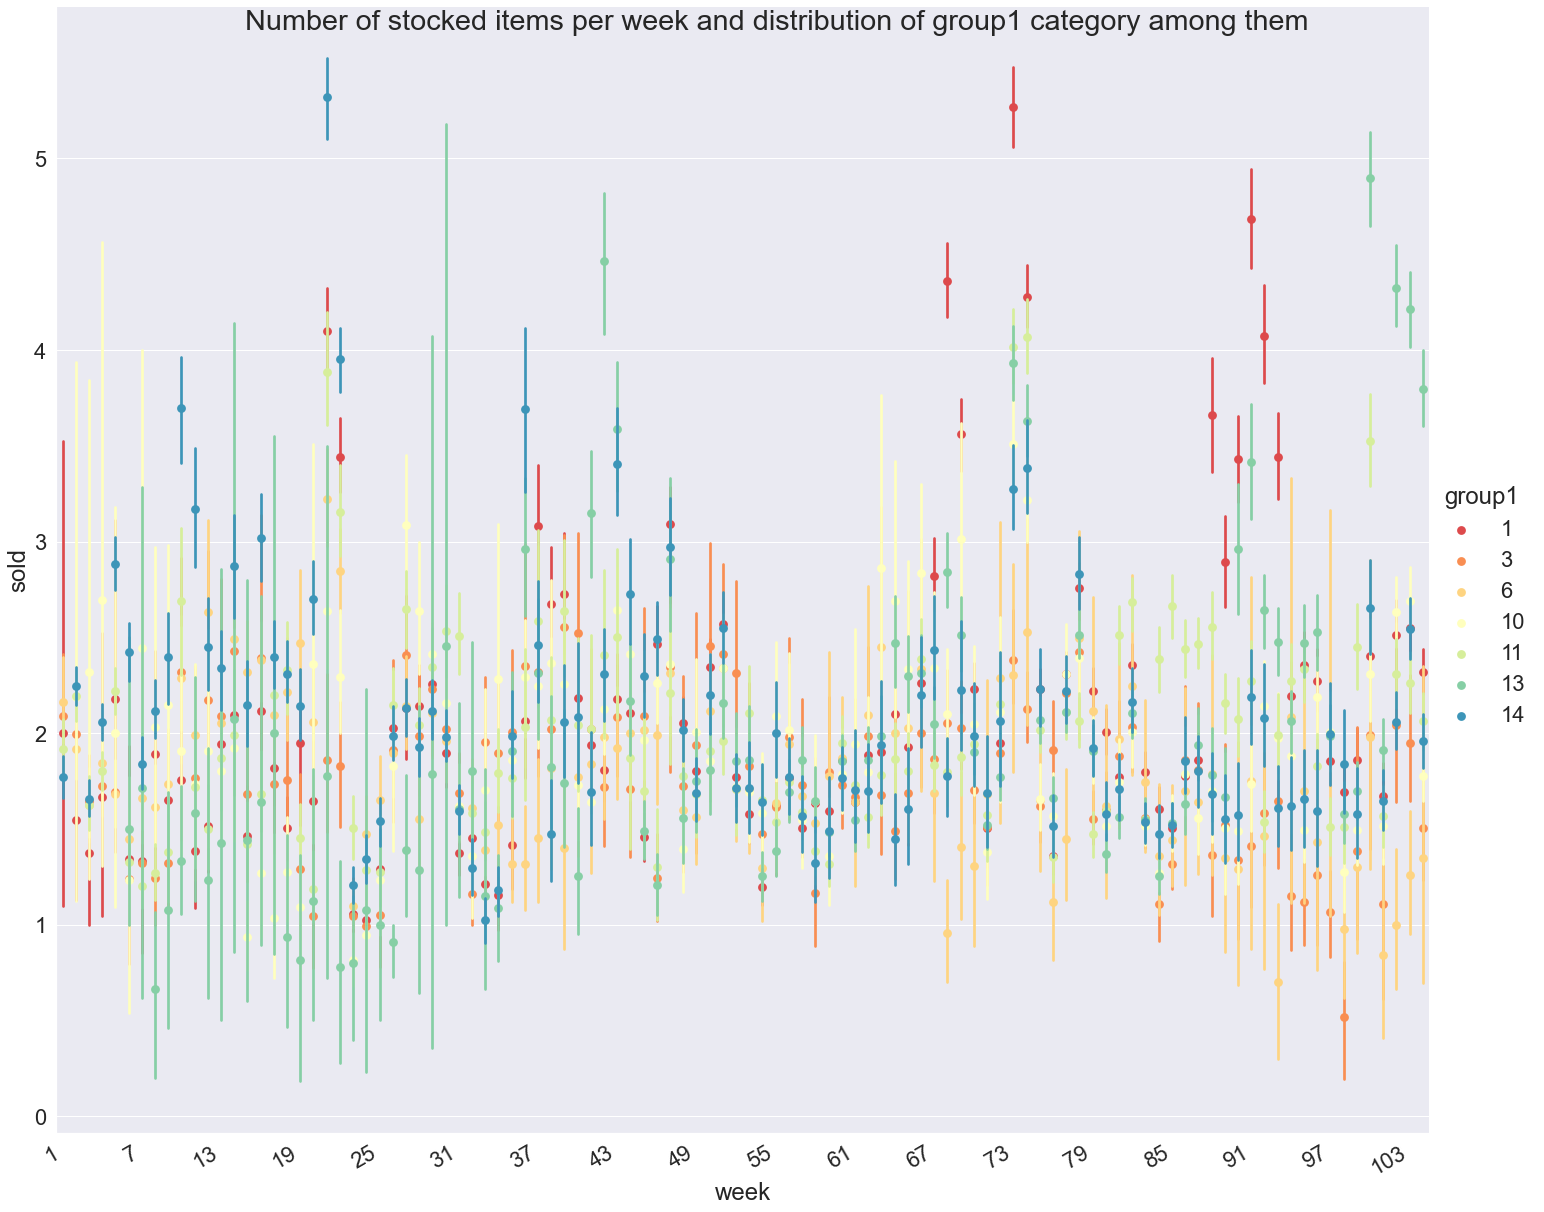

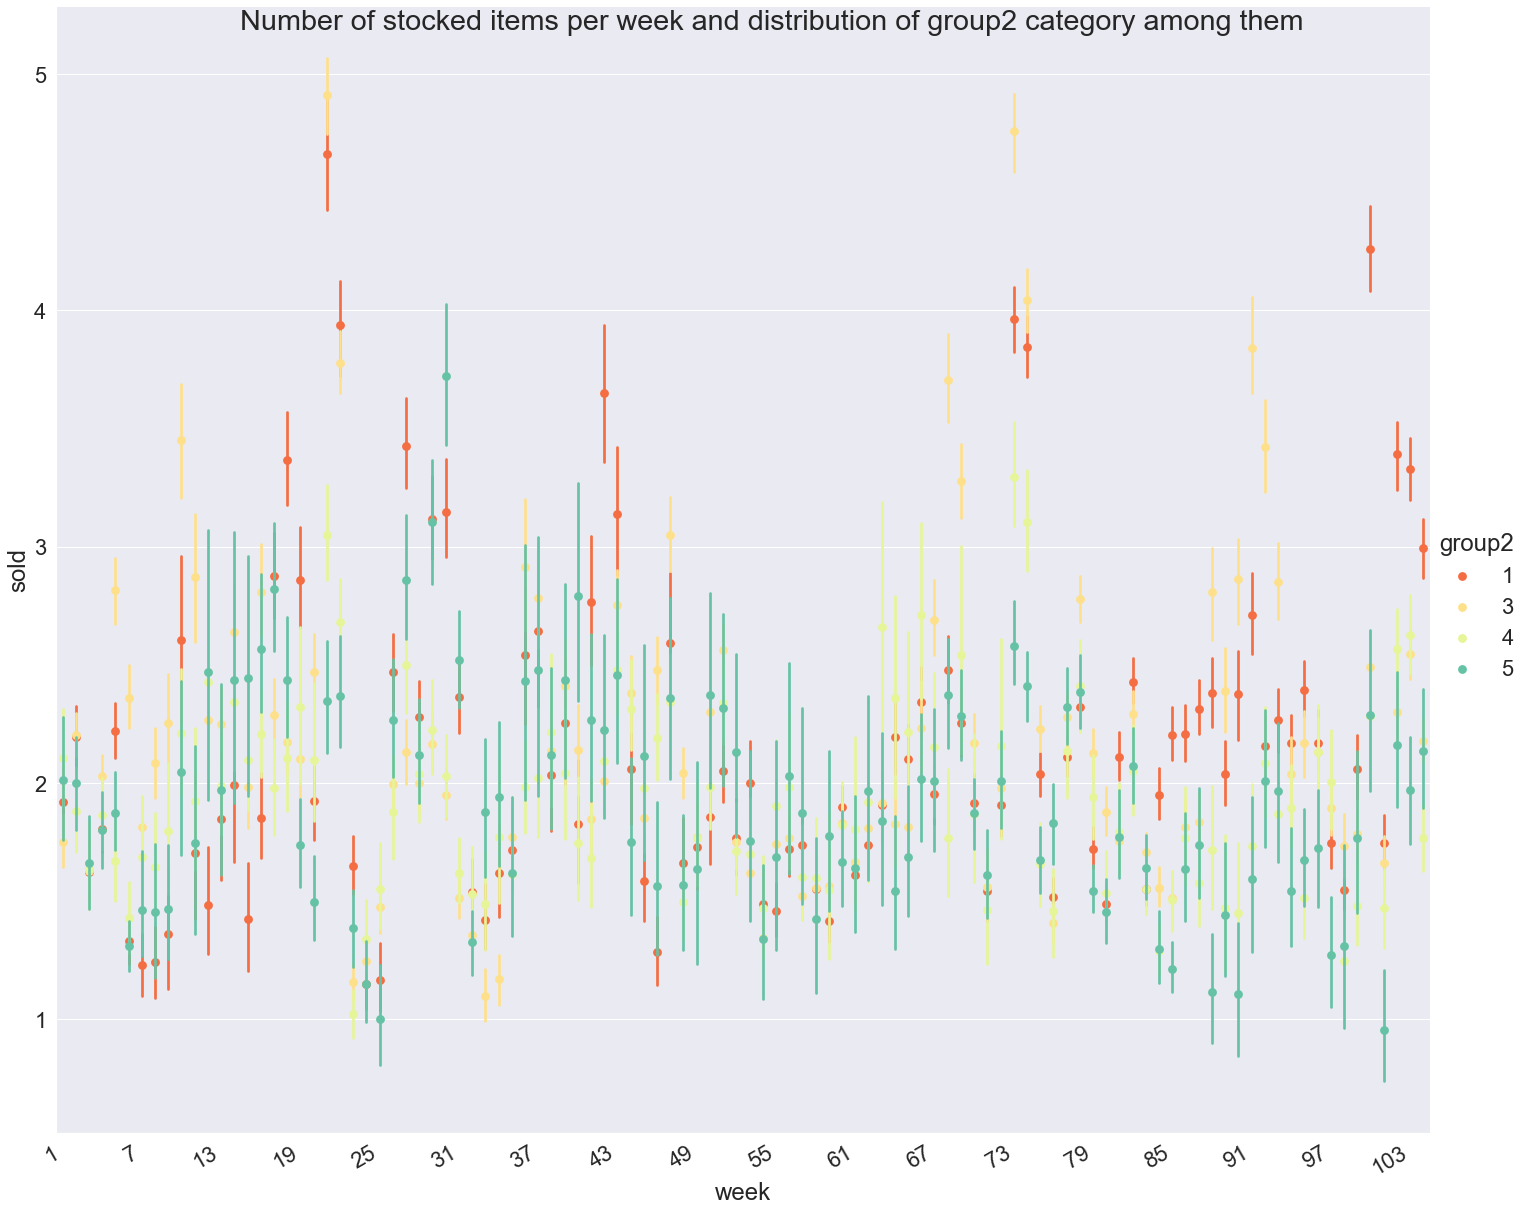

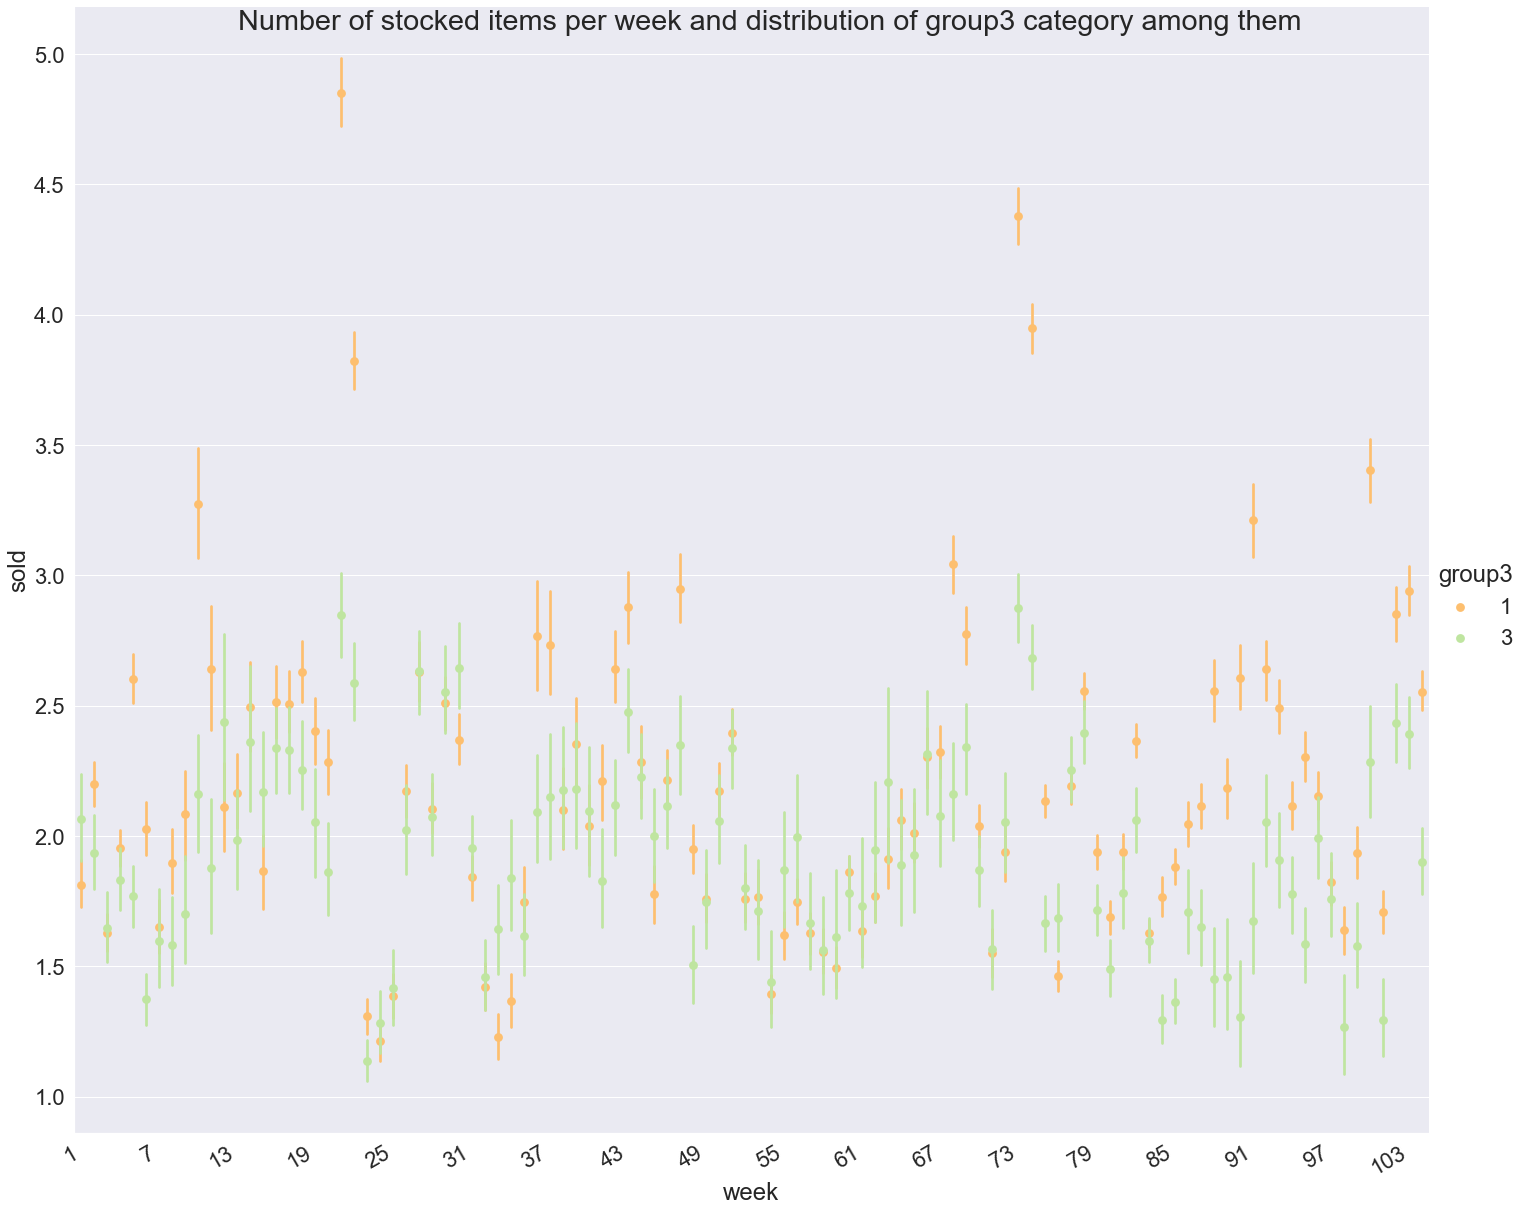

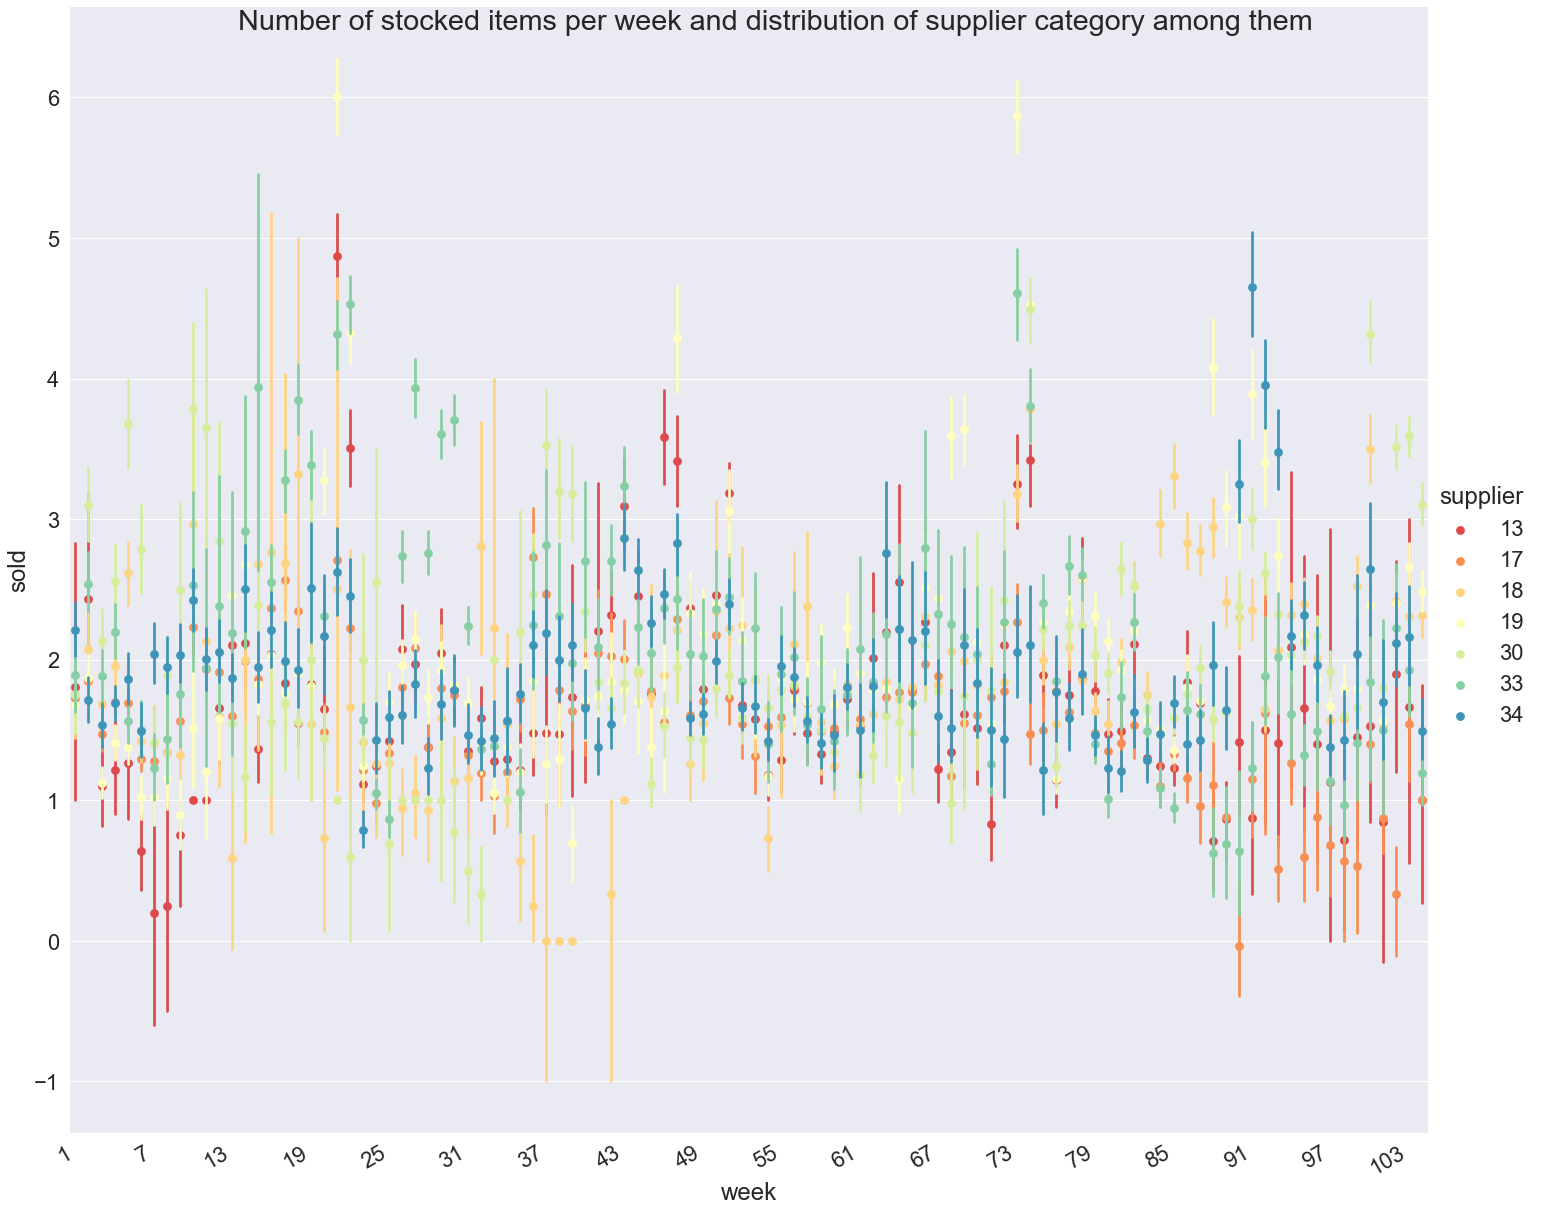

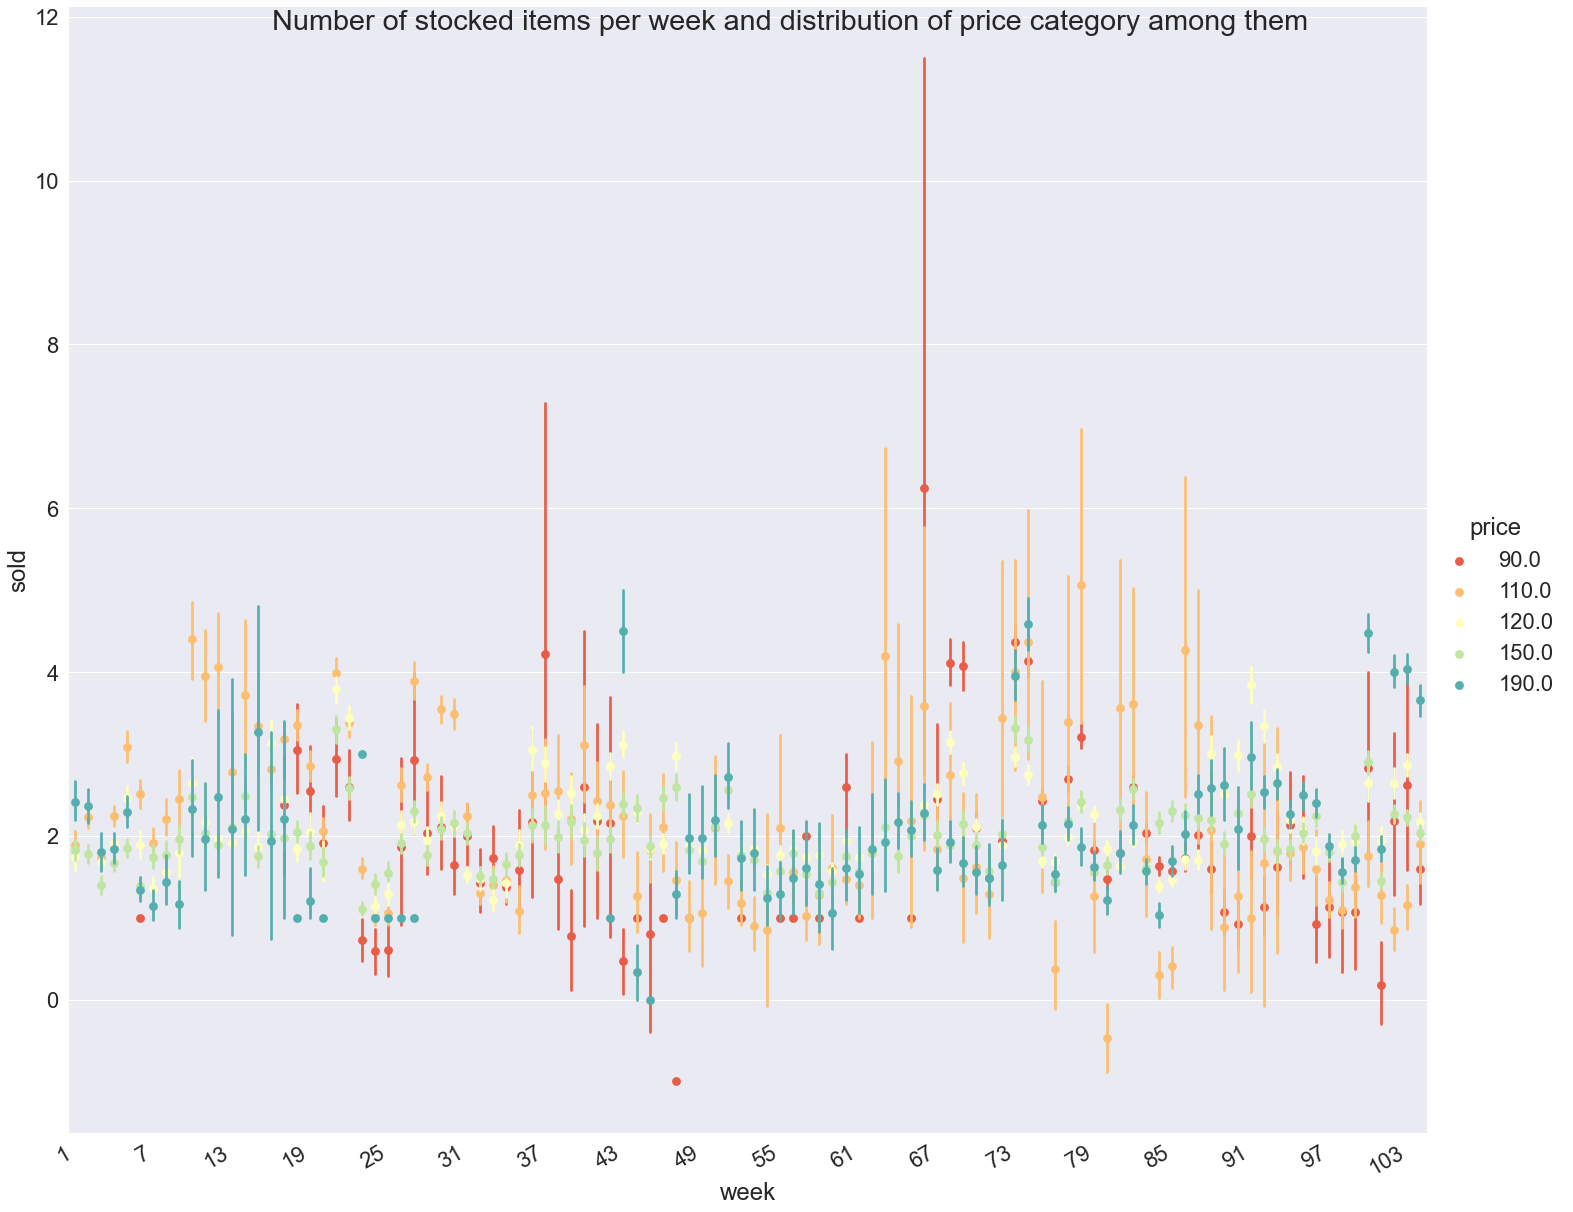

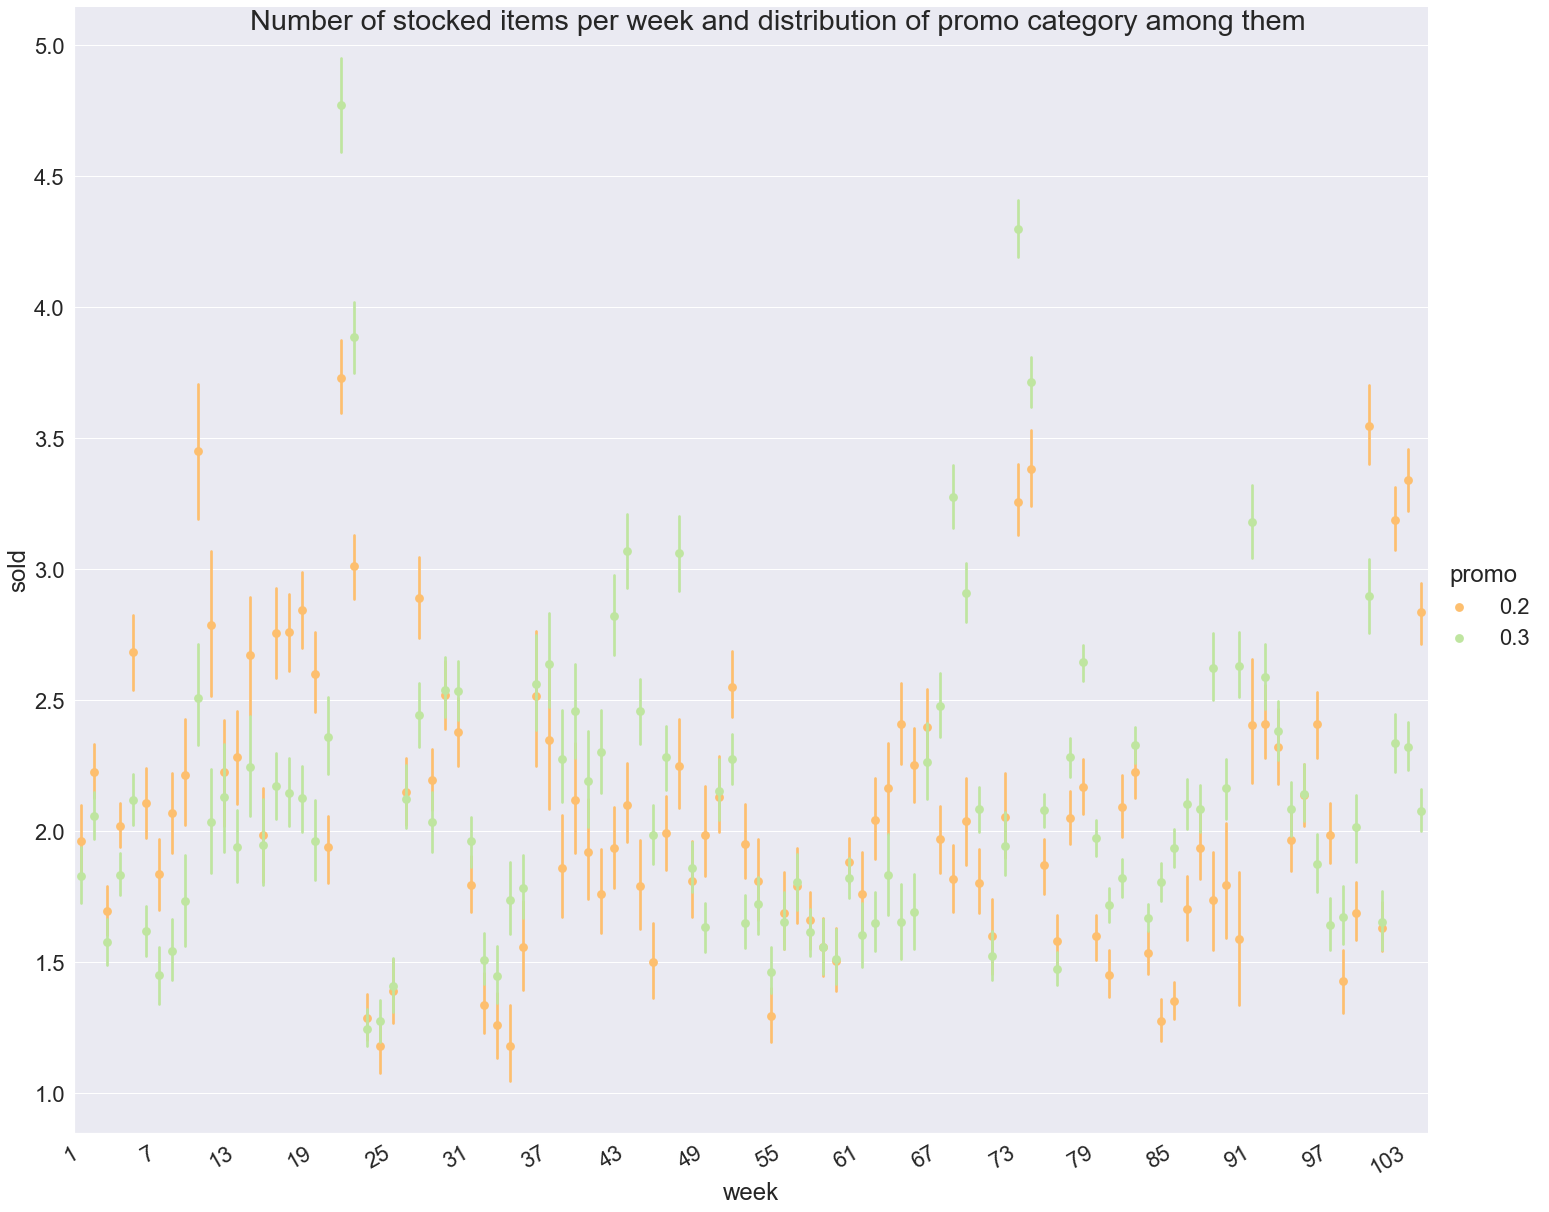

In [24]:
for f in features:
    timeseries_distribution_ratio(dataframe=df_b, feature=f, target='sold', time='week')

Gleaning insights from these sales trends is crucial for the success of a business. By delving into the intricacies of how and why certain products sell better than others, companies can make educated choices about managing their stock, determining prices, and creating effective marketing strategies. For instance, if a business is aware that a particular item typically sells briskly during the summer season, they can proactively increase their inventory to meet the anticipated demand. Furthermore, by understanding which features of a product are most attractive to customers at different points in the year, a business can tailor their marketing efforts to accentuate those particular aspects.